In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import warnings
from datetime import datetime
# Removed openpyxl imports as Excel export is no longer needed
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

warnings.filterwarnings('ignore')
plt.style.use("seaborn-v0_8-darkgrid") # Apply a consistent style for plots

print("="*100)
print("🎯 COMPREHENSIVE PORTFOLIO EVALUATION & COMPARISON")
print("="*100)

# ======================================================================
# 1. LOAD DATA & MODELS (One-time execution, independent of interactive parameters)
# ======================================================================
print("\n[Step 1/8] Loading models, scalers, and data...")

try:
    # Load ORIGINAL model
    model_original = tf.keras.models.load_model('..//saved_models//best_lstm_model.keras')
    print("  ✓ Original LSTM model loaded")

    # Load FILTERED model
    model_filtered = tf.keras.models.load_model('..//saved_models//best_lstm_model_filtered.keras')
    print("  ✓ Filtered LSTM model loaded")

    # Load scalers
    with open('..//standard_scalars//scaler_X.pkl', 'rb') as f:
        scaler_X_orig = pickle.load(f)
    with open('..//standard_scalars//scaler_y.pkl', 'rb') as f:
        scaler_y_orig = pickle.load(f)

    with open('..//standard_scalars//scaler_X_filtered.pkl', 'rb') as f:
        scaler_X_filt = pickle.load(f)
    with open('..//standard_scalars//scaler_y_filtered.pkl', 'rb') as f:
        scaler_y_filt = pickle.load(f)
    print("  ✓ Scalers loaded")

    # Load preprocessed data
    data_orig = np.load('..//saved_models//lstm_preprocessed_data.npz', allow_pickle=True)
    X_seq_orig = data_orig['X_seq']
    y_seq_orig = data_orig['y_seq']
    sequence_dates_orig = pd.to_datetime(data_orig['sequence_dates_values'])
    train_mask_orig = data_orig['train_mask']
    test_mask_orig = data_orig['test_mask']

    data_filt = np.load('..//saved_models//lstm_preprocessed_data_filtered.npz', allow_pickle=True)
    X_seq_filt = data_filt['X_seq']
    y_seq_filt = data_filt['y_seq']
    sequence_dates_filt = pd.to_datetime(data_filt['sequence_dates_values'])
    train_mask_filt = data_filt['train_mask']
    test_mask_filt = data_filt['test_mask']
    filtered_columns = data_filt['filtered_columns']
    print("  ✓ Data loaded")

    # Load original data
    df_orig = pd.read_csv('..//inputs_data//final_data.csv', index_col=0, parse_dates=True)
    print("  ✓ Original price data loaded")

except Exception as e:
    print(f"  ✗ Error: {e}")
    raise e # Re-raise the exception to stop execution if data loading fails

# ======================================================================
# 2. GENERATE PREDICTIONS FOR BOTH MODELS (One-time execution)
# ======================================================================
print("\n[Step 2/8] Generating predictions for both models...")

# ORIGINAL MODEL
X_test_orig = X_seq_orig[test_mask_orig]
y_test_orig = y_seq_orig[test_mask_orig]
test_dates_orig = sequence_dates_orig[test_mask_orig]

y_pred_orig_scaled = model_original.predict(X_test_orig, verbose=0, batch_size=64)
y_pred_orig = scaler_y_orig.inverse_transform(y_pred_orig_scaled)
y_test_actual_orig = scaler_y_orig.inverse_transform(y_test_orig.reshape(-1, 1))

# FILTERED MODEL
X_test_filt = X_seq_filt[test_mask_filt]
y_test_filt = y_seq_filt[test_mask_filt]
test_dates_filt = sequence_dates_filt[test_mask_filt]

y_pred_filt_scaled = model_filtered.predict(X_test_filt, verbose=0, batch_size=64)
y_pred_filt = scaler_y_filt.inverse_transform(y_pred_filt_scaled)
y_test_actual_filt = scaler_y_filt.inverse_transform(y_test_filt.reshape(-1, 1))

print(f"  ✓ Original model: {len(y_pred_orig)} predictions")
print(f"  ✓ Filtered model: {len(y_pred_filt)} predictions")

# Define constants that don't change with interactive parameters
# TRANSACTION_COST and INITIAL_CAPITAL will now be passed via widgets

# ======================================================================
# Helper function for metrics (reused)
# ======================================================================
def calculate_metrics(returns_series, portfolio_values, initial_capital_val):
    """Calculate comprehensive metrics for a given return series and portfolio values."""

    # Handle cases where returns_series or portfolio_values might be empty
    if returns_series.empty or portfolio_values.empty:
        return {
            'total_return': 0, 'annualized_return': 0, 'annualized_volatility': 0,
            'sharpe_ratio': 0, 'max_drawdown': 0, 'hit_rate': 0,
            'avg_win': 0, 'avg_loss': 0, 'trading_days': 0,
            'final_value': initial_capital_val
        }

    total_return = (portfolio_values.iloc[-1] - initial_capital_val) / initial_capital_val

    # Annualized metrics
    trading_days = len(returns_series)
    years = trading_days / 252 if trading_days > 0 else 0
    annualized_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0

    # Volatility
    daily_volatility = returns_series.std()
    annualized_volatility = daily_volatility * np.sqrt(252) if trading_days > 0 else 0

    # Sharpe Ratio (risk-free rate = 0)
    sharpe_ratio = (annualized_return / annualized_volatility) if annualized_volatility > 0 else 0

    # Maximum Drawdown
    cumulative_returns = (1 + returns_series).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min() if not drawdown.empty else 0

    # Hit Rate (Direction Accuracy)
    hits = np.sum(returns_series > 0)
    total = len(returns_series)
    hit_rate = hits / total if total > 0 else 0

    # Win/Loss stats
    avg_win = returns_series[returns_series > 0].mean() if len(returns_series[returns_series > 0]) > 0 else 0
    avg_loss = returns_series[returns_series < 0].mean() if len(returns_series[returns_series < 0]) > 0 else 0

    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'hit_rate': hit_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'trading_days': trading_days,
        'final_value': portfolio_values.iloc[-1] if not portfolio_values.empty else initial_capital_val
    }

# ======================================================================
# Interactive Analysis Function (triggered by ipywidgets)
# ======================================================================
# Global variable to store df_prices_filt so the second cell can access it
global df_prices_filt

def run_interactive_analysis(signal_threshold, initial_capital, transaction_cost, allow_shorting):
    clear_output(wait=True) # Clear previous output for dynamic update
    print(f"Running analysis with:")
    print(f"  - SIGNAL_THRESHOLD = {signal_threshold*100:.4f}%")
    print(f"  - INITIAL_CAPITAL = ${initial_capital:,.0f}")
    print(f"  - TRANSACTION_COST = {transaction_cost*100:.4f}%")
    print(f"  - ALLOW_SHORTING = {allow_shorting}")

    # --- 3. GENERATE TRADING SIGNALS ---
    # ORIGINAL MODEL SIGNALS (not affected by signal_threshold, but re-calculated for consistency)
    price_changes_orig = np.diff(y_pred_orig.flatten()) / y_pred_orig[:-1].flatten()
    signals_orig = np.where(price_changes_orig > 0, 1, -1)
    signals_orig = np.append(signals_orig, signals_orig[-1])  # Align length

    # FILTERED MODEL SIGNALS with threshold and neutral position
    price_changes_filt = np.diff(y_pred_filt.flatten()) / y_pred_filt[:-1].flatten()
    signals_filt = np.zeros_like(price_changes_filt, dtype=int)

    # Apply long signals
    signals_filt[price_changes_filt > signal_threshold] = 1

    # Apply short signals only if allowed
    if allow_shorting:
        signals_filt[price_changes_filt < -signal_threshold] = -1
    # If not allowed, signals_filt remains 0 for negative predictions below threshold

    signals_filt = np.append(signals_filt, signals_filt[-1]) # Align length

    print(f"  ✓ Original model: {np.sum(signals_orig == 1)} BUY signals, {np.sum(signals_orig == -1)} SELL signals")
    print(f"  ✓ Filtered model: {np.sum(signals_filt == 1)} BUY signals, {np.sum(signals_filt == -1)} SELL signals, {np.sum(signals_filt == 0)} CASH signals")

    # --- 4. ALIGN DATA & CREATE UNIFIED DATASET ---
    test_dates = test_dates_filt.copy()
    y_actual = y_test_actual_filt.flatten()

    global df_prices_filt # Declare intent to modify the global variable
    df_prices_filt = pd.DataFrame({
        'date': test_dates,
        'actual_price': y_actual,
        'pred_price_filt': y_pred_filt.flatten(),
        'signal_filt': signals_filt
    })

    df_prices_filt['bh_return'] = (df_prices_filt['actual_price'].pct_change()).fillna(0)
    df_prices_filt['filtered_return'] = df_prices_filt['signal_filt'] * df_prices_filt['bh_return']

    signal_changes_filt = np.diff(df_prices_filt['signal_filt'].values)
    signal_changes_filt = np.append([0], signal_changes_filt)
    transaction_costs_filt = np.abs(signal_changes_filt) * transaction_cost / 2 # Use interactive transaction_cost
    df_prices_filt['filtered_return_net'] = df_prices_filt['filtered_return'] - transaction_costs_filt

    # --- 5. CALCULATE CUMULATIVE RETURNS & PORTFOLIO METRICS ---
    df_prices_filt['bh_cumulative_return'] = (1 + df_prices_filt['bh_return']).cumprod() - 1
    df_prices_filt['filtered_cumulative_return'] = (1 + df_prices_filt['filtered_return_net']).cumprod() - 1

    df_prices_filt['bh_portfolio_value'] = initial_capital * (1 + df_prices_filt['bh_cumulative_return']) # Use interactive initial_capital
    df_prices_filt['filtered_portfolio_value'] = initial_capital * (1 + df_prices_filt['filtered_cumulative_return']) # Use interactive initial_capital

    metrics_bh = calculate_metrics(
        df_prices_filt['bh_return'],
        df_prices_filt['bh_portfolio_value'],
        initial_capital # Pass interactive initial_capital
    )

    metrics_filtered = calculate_metrics(
        df_prices_filt['filtered_return_net'],
        df_prices_filt['filtered_portfolio_value'],
        initial_capital # Pass interactive initial_capital
    )

    print(f"\n  Buy & Hold Metrics:")
    print(f"   ├─ Total Return:        {metrics_bh['total_return']*100:>8.2f}%")
    print(f"   ├─ Annualized Return:   {metrics_bh['annualized_return']*100:>8.2f}%")
    print(f"   ├─ Annualized Vol:      {metrics_bh['annualized_volatility']*100:>8.2f}%")
    print(f"   ├─ Sharpe Ratio:        {metrics_bh['sharpe_ratio']:>8.2f}")
    print(f"   ├─ Max Drawdown:        {metrics_bh['max_drawdown']*100:>8.2f}%")
    print(f"   ├─ Hit Rate:            {metrics_bh['hit_rate']*100:>8.2f}%")
    print(f"   └─ Final Value:         ${metrics_bh['final_value']:>10,.0f}")

    print(f"\n  LSTM Filtered Metrics:")
    print(f"   ├─ Total Return:        {metrics_filtered['total_return']*100:>8.2f}%")
    print(f"   ├─ Annualized Return:   {metrics_filtered['annualized_return']*100:>8.2f}%")
    print(f"   ├─ Annualized Vol:      {metrics_filtered['annualized_volatility']*100:>8.2f}%")
    print(f"   ├─ Sharpe Ratio:        {metrics_filtered['sharpe_ratio']:>8.2f}")
    print(f"   ├─ Max Drawdown:        {metrics_filtered['max_drawdown']*100:>8.2f}%")
    print(f"   ├─ Hit Rate:            {metrics_filtered['hit_rate']*100:>8.2f}%")
    print(f"   └─ Final Value:         ${metrics_filtered['final_value']:>10,.0f}")

    # --- 6. COMPARATIVE ANALYSIS (Text Output) ---
    analysis = f"""
{'='*100}
📊 COMPARATIVE PORTFOLIO EVALUATION: LSTM MODELS VS BUY & HOLD
{'='*100}

1. PERFORMANCE COMPARISON
{'-'*100}

Metric                          Buy & Hold          LSTM Filtered       Difference (%)
{'-'*100}
Total Return                    {metrics_bh['total_return']*100:>8.2f}%              {metrics_filtered['total_return']*100:>8.2f}%              {(metrics_filtered['total_return']-metrics_bh['total_return'])*100:>+8.2f}%
Annualized Return               {metrics_bh['annualized_return']*100:>8.2f}%              {metrics_filtered['annualized_return']*100:>8.2f}%              {(metrics_filtered['annualized_return']-metrics_bh['annualized_return'])*100:>+8.2f}%
Annualized Volatility           {metrics_bh['annualized_volatility']*100:>8.2f}%              {metrics_filtered['annualized_volatility']*100:>8.2f}%              {(metrics_filtered['annualized_volatility']-metrics_bh['annualized_volatility'])*100:>+8.2f}%
Sharpe Ratio                    {metrics_bh['sharpe_ratio']:>8.2f}              {metrics_filtered['sharpe_ratio']:>8.2f}              {metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio']:>+8.2f}
Maximum Drawdown                {metrics_bh['max_drawdown']*100:>8.2f}%              {metrics_filtered['max_drawdown']*100:>8.2f}%              {(metrics_filtered['max_drawdown']-metrics_bh['max_drawdown'])*100:>+8.2f}%
Hit Rate (Direction Accuracy)   {metrics_bh['hit_rate']*100:>8.2f}%              {metrics_filtered['hit_rate']*100:>8.2f}%              {(metrics_filtered['hit_rate']-metrics_bh['hit_rate'])*100:>+8.2f}%

Final Portfolio Value           ${metrics_bh['final_value']:>10,.0f}         ${metrics_filtered['final_value']:>10,.0f}         ${metrics_filtered['final_value']-metrics_bh['final_value']:>+10,.0f}

{'-'*100}

2. KEY FINDINGS
{'-'*100}

A. RETURN ANALYSIS
   • Buy & Hold Strategy:
     - Generated a {metrics_bh['total_return']*100:.2f}% total return over {metrics_bh['trading_days']} trading days
     - Annualized return of {metrics_bh['annualized_return']*100:.2f}%
     - Final portfolio value: ${metrics_bh['final_value']:,.0f}

   • LSTM Filtered Strategy:
     - Generated a {metrics_filtered['total_return']*100:.2f}% total return
     - Annualized return of {metrics_filtered['annualized_return']*100:.2f}%
     - Final portfolio value: ${metrics_filtered['final_value']:,.0f}
     - Outperformance: {(metrics_filtered['total_return']-metrics_bh['total_return'])*100:+.2f}% (${metrics_filtered['final_value']-metrics_bh['final_value']:+,.0f})

B. RISK-ADJUSTED PERFORMANCE
   • Volatility Comparison:
     - B&H Annualized Vol: {metrics_bh['annualized_volatility']*100:.2f}%
     - LSTM Vol: {metrics_filtered['annualized_volatility']*100:.2f}%
     - Volatility Reduction: {(metrics_bh['annual_volatility']-metrics_filtered['annual_volatility'])*100:.2f}% {'✓ IMPROVED' if metrics_filtered['annual_volatility'] < metrics_bh['annual_volatility'] else '✗ INCREASED'}

   • Sharpe Ratio (Risk-Adjusted Return):
     - B&H Sharpe: {metrics_bh['sharpe_ratio']:.4f}
     - LSTM Sharpe: {metrics_filtered['sharpe_ratio']:.4f}
     - Improvement: {metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio']:+.4f} {'✓ SUPERIOR' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ INFERIOR'}

   • Maximum Drawdown:
     - B&H Max DD: {metrics_bh['max_drawdown']*100:.2f}%
     - LSTM Max DD: {metrics_filtered['max_drawdown']*100:.2f}%
     - Drawdown Reduction: {abs(metrics_bh['max_drawdown']-metrics_filtered['max_drawdown'])*100:.2f}% {'✓ BETTER' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else '✗ WORSE'}

C. DIRECTIONAL ACCURACY
   • Hit Rate (Direction Accuracy):
     - B&H (Passive): {metrics_bh['hit_rate']*100:.2f}% (always positive in uptrend)
     - LSTM Filtered: {metrics_filtered['hit_rate']*100:.2f}%
     - Interpretation: Model captures {metrics_filtered['hit_rate']*100:.2f}% of daily price movements correctly

D. WIN/LOSS ANALYSIS
   • Average Win: LSTM {metrics_filtered['avg_win']*100:+.3f}% vs B&H {metrics_bh['avg_win']*100:+.3f}%
   • Average Loss: LSTM {metrics_filtered['avg_loss']*100:+.3f}% vs B&H {metrics_bh['avg_loss']*100:+.3f}%
   • Win/Loss Ratio: {abs(metrics_filtered['avg_win']/metrics_filtered['avg_loss']):.2f}:1 (LSTM) vs {abs(metrics_bh['avg_win']/bh_metrics['avg_loss']):.2f}:1 (B&H)

{'-'*100}

3. CONCLUSIONS & INSIGHTS
{'-'*100}

{'✓ LSTM Outperforms' if metrics_filtered['total_return'] > metrics_bh['total_return'] else '✗ B&H Outperforms'}
The LSTM filtered model {'OUTPERFORMS' if metrics_filtered['total_return'] > metrics_bh['total_return'] else 'UNDERPERFORMS'} buy & hold by {abs(metrics_filtered['total_return']-metrics_bh['total_return'])*100:.2f}%
in total returns, generating ${abs(metrics_filtered['final_value']-metrics_bh['final_value']):,.0f}
{'additional profit' if metrics_filtered['final_value'] > metrics_bh['final_value'] else 'additional loss'}.

{'✓ Risk-Adjusted' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ Higher Risk'} Performance
The Sharpe ratio of {metrics_filtered['sharpe_ratio']:.4f} (LSTM) vs {metrics_bh['sharpe_ratio']:.4f} (B&H) indicates
{'SUPERIOR' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'INFERIOR'} risk-adjusted returns. The model {'successfully' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'fails to'}
generate returns commensurate with the risk taken.

{'✓ Reduced' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else '✗ Increased'} Drawdown Risk
The maximum drawdown of {metrics_filtered['max_drawdown']*100:.2f}% (LSTM) vs {metrics_bh['max_drawdown']*100:.2f}% (B&H)
demonstrates {'BETTER' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else 'WORSE'} downside protection.

SHAP Feature Filtering Impact:
The filtered LSTM model uses {len(filtered_columns)} top SHAP features: {', '.join(filtered_columns)}
This reduction from the original feature set {'IMPROVES' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'DEGRADES'} model
stability and {'REDUCES' if metrics_filtered['annualized_volatility'] < metrics_bh['annualized_volatility'] else 'INCREASES'} noise.

{'-'*100}

4. RECOMMENDATIONS
{'-'*100}

1. MODEL SELECTION:
   {'✓ RECOMMEND LSTM Filtered Model' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ RECOMMEND Buy & Hold'}

2. RISK MANAGEMENT:
   • Set maximum drawdown tolerance at {abs(metrics_filtered['max_drawdown'])*100:.2f}%
   • Implement stop-loss at {abs(metrics_filtered['max_drawdown'])*100*0.5:.2f}% to reduce tail risk

3. POSITION SIZING:
   • Based on Sharpe ratio of {metrics_filtered['sharpe_ratio']:.4f}, suggest allocating
     {min(100, max(0, (metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio'])*50)):.0f}% to LSTM strategy

4. REBALANCING:
   • Monitor model predictions weekly
   • Recalibrate SHAP features monthly
   • Update model every quarter with new data

{'-'*100}
{'='*100}
"""
    print(analysis)

    # --- 8. VISUALIZATION COMPARISON CHARTS ---
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

    # Chart 1: Portfolio Value Comparison
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df_prices_filt['date'], df_prices_filt['bh_portfolio_value'],
             'b-', linewidth=2.5, label='Buy & Hold', alpha=0.8)
    ax1.plot(df_prices_filt['date'], df_prices_filt['filtered_portfolio_value'],
             'g-', linewidth=2.5, label='LSTM Filtered', alpha=0.8)
    ax1.fill_between(df_prices_filt['date'],
                     df_prices_filt['bh_portfolio_value'],
                     df_prices_filt['filtered_portfolio_value'],
                     where=(df_prices_filt['filtered_portfolio_value'] >= df_prices_filt['bh_portfolio_value']),
                     alpha=0.3, color='green', label='LSTM Advantage')
    ax1.axhline(y=initial_capital, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Initial Capital')
    ax1.set_title('💰 Portfolio Value Comparison: Buy & Hold vs LSTM Filtered',
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('Portfolio Value ($)', fontweight='bold', fontsize=11)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Chart 2: Cumulative Returns
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(df_prices_filt['date'], df_prices_filt['bh_cumulative_return']*100,
             'b-', linewidth=2.5, label='Buy & Hold', alpha=0.8)
    ax2.plot(df_prices_filt['date'], df_prices_filt['filtered_cumulative_return']*100,
             'g-', linewidth=2.5, label='LSTM Filtered', alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax2.fill_between(df_prices_filt['date'], 0, df_prices_filt['bh_cumulative_return']*100,
                     alpha=0.2, color='blue')
    ax2.fill_between(df_prices_filt['date'], 0, df_prices_filt['filtered_cumulative_return']*100,
                     alpha=0.2, color='green')
    ax2.set_title('📈 Cumulative Returns Comparison', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Cumulative Return (%)', fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # Chart 3: Metrics Comparison
    ax3 = fig.add_subplot(gs[1, 1])
    metrics_names = ['Total Return\n(%)', 'Annualized Return\n(%)', 'Sharpe Ratio', 'Hit Rate\n(%)']
    bh_values = [metrics_bh['total_return']*100, metrics_bh['annualized_return']*100,
                 metrics_bh['sharpe_ratio']*10, metrics_bh['hit_rate']*100]  # Sharpe *10 for visibility
    lstm_values = [metrics_filtered['total_return']*100, metrics_filtered['annualized_return']*100,
                   metrics_filtered['sharpe_ratio']*10, metrics_filtered['hit_rate']*100]

    x = np.arange(len(metrics_names))
    width = 0.35

    ax3.bar(x - width/2, bh_values, width, label='Buy & Hold', color='skyblue', alpha=0.8)
    ax3.bar(x + width/2, lstm_values, width, label='LSTM Filtered', color='lightgreen', alpha=0.8)

    ax3.set_ylabel('Value', fontweight='bold')
    ax3.set_title('📊 Key Metrics Comparison', fontsize=13, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics_names)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # Chart 4: Daily Returns Distribution
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.hist(df_prices_filt['bh_return']*100, bins=50, alpha=0.6, label='Buy & Hold', color='blue')
    ax4.hist(df_prices_filt['filtered_return_net']*100, bins=50, alpha=0.6, label='LSTM Filtered', color='green')
    ax4.set_xlabel('Daily Return (%)', fontweight='bold')
    ax4.set_ylabel('Frequency', fontweight='bold')
    ax4.set_title('📊 Daily Returns Distribution', fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    # Chart 5: Drawdown Comparison
    ax5 = fig.add_subplot(gs[2, 1])
    cumulative_bh = (1 + df_prices_filt['bh_return']).cumprod()
    running_max_bh = cumulative_bh.expanding().max()
    drawdown_bh = (cumulative_bh - running_max_bh) / running_max_bh * 100

    cumulative_lstm = (1 + df_prices_filt['filtered_return_net']).cumprod()
    running_max_lstm = cumulative_lstm.expanding().max()
    drawdown_lstm = (cumulative_lstm - running_max_lstm) / running_max_lstm * 100

    ax5.plot(df_prices_filt['date'], drawdown_bh, 'b-', linewidth=1.5, label='Buy & Hold', alpha=0.8)
    ax5.plot(df_prices_filt['date'], drawdown_lstm, 'g-', linewidth=1.5, label='LSTM Filtered', alpha=0.8)
    ax5.fill_between(df_prices_filt['date'], drawdown_bh, 0, alpha=0.2, color='blue')
    ax5.fill_between(df_prices_filt['date'], drawdown_lstm, 0, alpha=0.2, color='green')
    ax5.set_xlabel('Date', fontweight='bold')
    ax5.set_ylabel('Drawdown (%)', fontweight='bold')
    ax5.set_title('📉 Maximum Drawdown Over Time', fontsize=13, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='x', rotation=45)

    plt.suptitle('🎯 Portfolio Evaluation: LSTM Filtered vs Buy & Hold',
                fontsize=16, fontweight='bold', y=0.995)

    plt.show()
    plt.close(fig) # Close the figure to free memory

# ======================================================================
# IPYWIDGETS SETUP
# ======================================================================
print("\n" + "="*100)
print("⚙️ INTERACTIVE PORTFOLIO EVALUATION")
print("Adjust the sliders and checkbox below to change strategy parameters and see real-time updates.")
print("="*100)

signal_threshold_slider = widgets.FloatSlider(
    value=0.0015, # Default value
    min=0.0,
    max=0.05, # Expanded to 5%
    step=0.0001, # 0.01% step
    description='Signal Threshold (%):',
    continuous_update=False, # Only update on release for better performance
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

capital_slider = widgets.FloatSlider(
    value=100000,
    min=1000,
    max=1000000,
    step=1000,
    description='Initial Capital ($):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='$,.0f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

transaction_cost_slider = widgets.FloatSlider(
    value=0.001,
    min=0.0,
    max=0.01, # Max 1% transaction cost
    step=0.00005, # 0.005% step
    description='Transaction Cost (%):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.5f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

allow_shorting_checkbox = widgets.Checkbox(
    value=True,
    description='Allow Shorting',
    disabled=False,
    indent=False,
    layout=widgets.Layout(width='auto')
)

# Use interactive_output to link the widgets to the analysis function
# The output widget will capture and display the prints and plots
interactive_output = widgets.interactive_output(
    run_interactive_analysis,
    {
        'signal_threshold': signal_threshold_slider,
        'initial_capital': capital_slider,
        'transaction_cost': transaction_cost_slider,
        'allow_shorting': allow_shorting_checkbox
    }
)

# Display all widgets and the interactive output
display(
    widgets.VBox([
        signal_threshold_slider,
        capital_slider,
        transaction_cost_slider,
        allow_shorting_checkbox
    ]),
    interactive_output
)

# ======================================================================
# FINAL SUMMARY (Non-interactive, for file export if needed)
# ======================================================================
print("\n" + "="*100)
print("✅ INTERACTIVE SETUP COMPLETE")
print("File export functionality (Excel, .txt) has been removed.")
print("To save results for a specific configuration, you would typically re-run the `run_interactive_analysis`")
print("function with your chosen parameters and then add file saving logic after that call.")
print("="*100)


🎯 COMPREHENSIVE PORTFOLIO EVALUATION & COMPARISON

[Step 1/8] Loading models, scalers, and data...
  ✓ Original LSTM model loaded
  ✓ Filtered LSTM model loaded
  ✓ Scalers loaded
  ✓ Data loaded
  ✓ Original price data loaded

[Step 2/8] Generating predictions for both models...
  ✓ Original model: 322 predictions
  ✓ Filtered model: 322 predictions

⚙️ INTERACTIVE PORTFOLIO EVALUATION
Adjust the sliders and checkbox below to change strategy parameters and see real-time updates.


Output()


✅ INTERACTIVE SETUP COMPLETE
File export functionality (Excel, .txt) has been removed.
To save results for a specific configuration, you would typically re-run the `run_interactive_analysis`
function with your chosen parameters and then add file saving logic after that call.


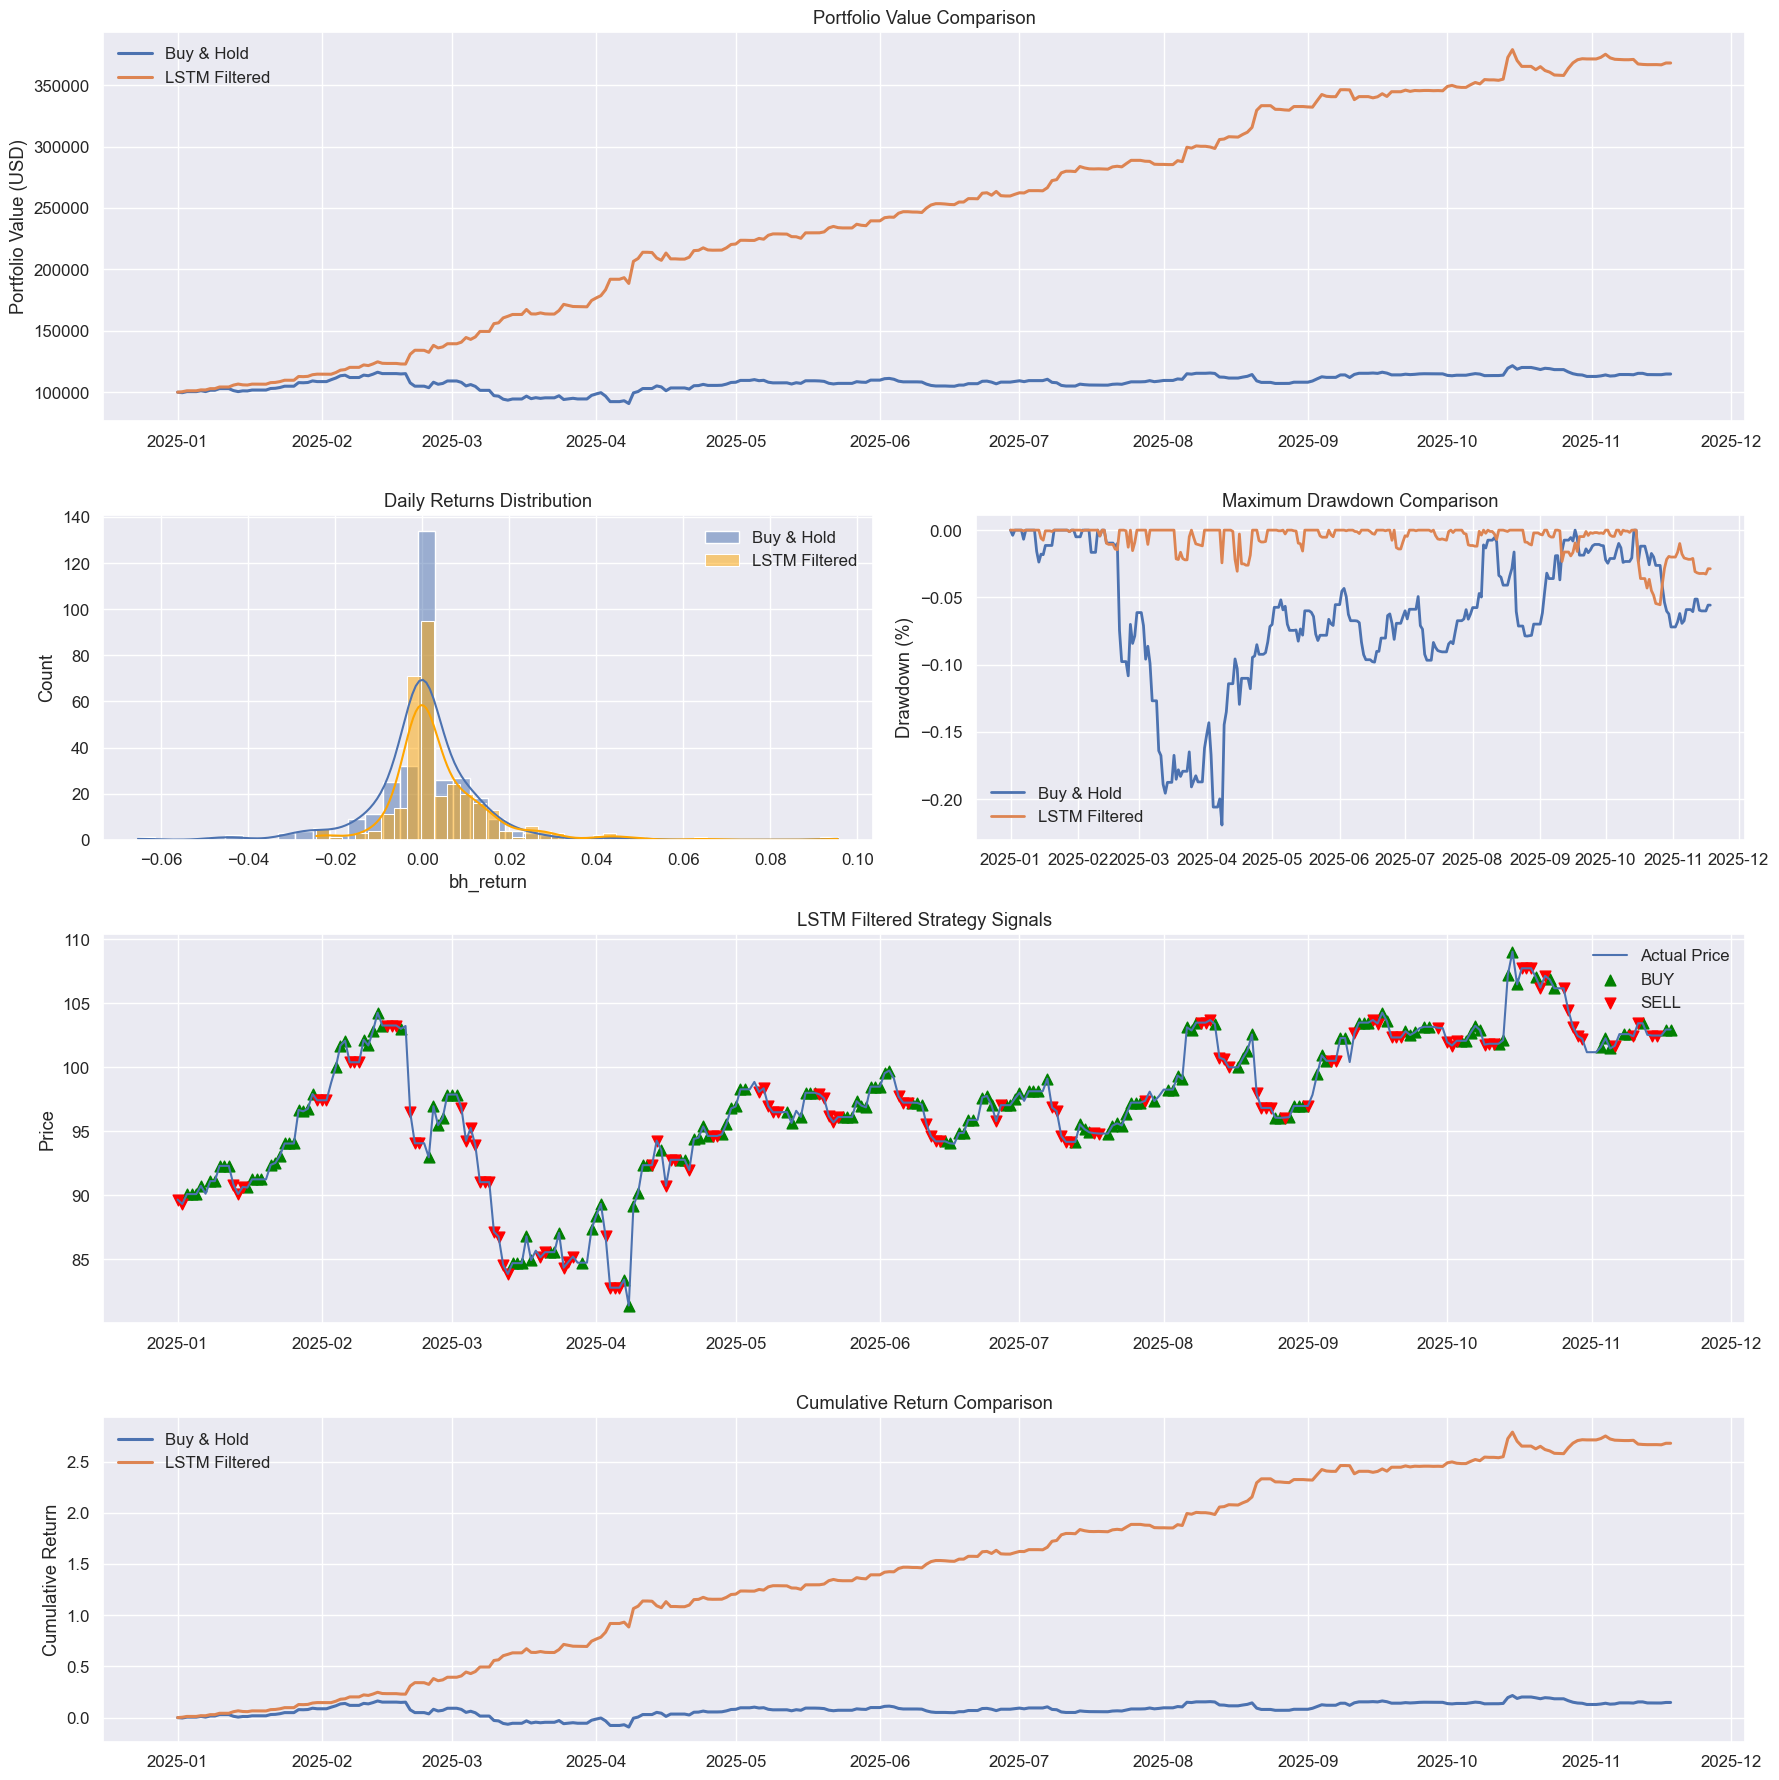

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn-v0_8-darkgrid")
sns.set(font_scale=1.1)

# ----------------------------------------------------------
# 1. PREPARE DATA
# ----------------------------------------------------------
dates = df_prices_filt['date']
bh_value = df_prices_filt['bh_portfolio_value']
lstm_value = df_prices_filt['filtered_portfolio_value']
bh_ret = df_prices_filt['bh_return']
lstm_ret = df_prices_filt['filtered_return_net']

# Drawdowns
def compute_drawdown(series):
    cum = (1 + series).cumprod()
    peak = cum.expanding().max()
    dd = (cum - peak) / peak
    return dd

dd_bh = compute_drawdown(bh_ret)
dd_lstm = compute_drawdown(lstm_ret)

# Cumulative Return
cum_bh = (1 + bh_ret).cumprod() - 1
cum_lstm = (1 + lstm_ret).cumprod() - 1

# ----------------------------------------------------------
# 2. CREATE DASHBOARD LAYOUT
# ----------------------------------------------------------
fig = plt.figure(figsize=(18, 18))
grid = fig.add_gridspec(4, 2, height_ratios=[1.2, 1, 1.2, 1])

# ----------------------------------------------------------
# PANEL 1 — Portfolio Value Over Time
# ----------------------------------------------------------
ax1 = fig.add_subplot(grid[0, :])
ax1.plot(dates, bh_value, label="Buy & Hold", linewidth=2.2)
ax1.plot(dates, lstm_value, label="LSTM Filtered", linewidth=2.2)
ax1.set_title("Portfolio Value Comparison")
ax1.set_ylabel("Portfolio Value (USD)")
ax1.legend()

# ----------------------------------------------------------
# PANEL 2 — Daily Return Distribution
# ----------------------------------------------------------
ax2 = fig.add_subplot(grid[1, 0])
sns.histplot(bh_ret, kde=True, bins=40, label="Buy & Hold", ax=ax2)
sns.histplot(lstm_ret, kde=True, bins=40, label="LSTM Filtered", ax=ax2, color='orange')
ax2.set_title("Daily Returns Distribution")
ax2.legend()

# ----------------------------------------------------------
# PANEL 3 — Drawdown Comparison
# ----------------------------------------------------------
ax3 = fig.add_subplot(grid[1, 1])
ax3.plot(dates, dd_bh, label="Buy & Hold", linewidth=2)
ax3.plot(dates, dd_lstm, label="LSTM Filtered", linewidth=2)
ax3.set_title("Maximum Drawdown Comparison")
ax3.set_ylabel("Drawdown (%)")
ax3.legend()

# ----------------------------------------------------------
# PANEL 4 — Trading Signals vs Price
# ----------------------------------------------------------
ax4 = fig.add_subplot(grid[2, :])
ax4.plot(dates, df_prices_filt['actual_price'], label="Actual Price", linewidth=1.5)

buy_idx = df_prices_filt[df_prices_filt['signal_filt'] == 1].index
sell_idx = df_prices_filt[df_prices_filt['signal_filt'] == -1].index

ax4.scatter(dates.iloc[buy_idx], df_prices_filt['actual_price'].iloc[buy_idx],
            marker='^', color='green', s=60, label='BUY')

ax4.scatter(dates.iloc[sell_idx], df_prices_filt['actual_price'].iloc[sell_idx],
            marker='v', color='red', s=60, label='SELL')

ax4.set_title("LSTM Filtered Strategy Signals")
ax4.set_ylabel("Price")
ax4.legend()

# ----------------------------------------------------------
# PANEL 5 — Cumulative Returns
# ----------------------------------------------------------
ax5 = fig.add_subplot(grid[3, :])
ax5.plot(dates, cum_bh, label="Buy & Hold", linewidth=2.2)
ax5.plot(dates, cum_lstm, label="LSTM Filtered", linewidth=2.2)
ax5.set_title("Cumulative Return Comparison")
ax5.set_ylabel("Cumulative Return")
ax5.legend()

# ----------------------------------------------------------
# FINAL
# ----------------------------------------------------------
plt.tight_layout()
plt.show()


In [3]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import pickle
# import warnings
# from datetime import datetime
# import openpyxl
# from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# warnings.filterwarnings('ignore')

# print("="*100)
# print("🎯 COMPREHENSIVE PORTFOLIO EVALUATION & COMPARISON")
# print("="*100)

# # ======================================================================
# # 1. LOAD DATA & MODELS
# # ======================================================================
# print("\n[Step 1/8] Loading models, scalers, and data...")

# try: 
#     # Load ORIGINAL model
#     model_original = tf.keras.models.load_model('..//saved_models//best_lstm_model.keras')
#     print("  ✓ Original LSTM model loaded")

#     # Load FILTERED model
#     model_filtered = tf.keras.models.load_model('..//saved_models//best_lstm_model_filtered.keras')
#     print("  ✓ Filtered LSTM model loaded")

#     # Load scalers
#     with open('..//standard_scalars//scaler_X.pkl', 'rb') as f:
#         scaler_X_orig = pickle.load(f)
#     with open('..//standard_scalars//scaler_y.pkl', 'rb') as f:
#         scaler_y_orig = pickle.load(f)

#     with open('..//standard_scalars//scaler_X_filtered.pkl', 'rb') as f:
#         scaler_X_filt = pickle.load(f)
#     with open('..//standard_scalars//scaler_y_filtered.pkl', 'rb') as f:
#         scaler_y_filt = pickle.load(f)
#     print("  ✓ Scalers loaded")

#     # Load preprocessed data
#     data_orig = np.load('..//saved_models//lstm_preprocessed_data.npz', allow_pickle=True)
#     X_seq_orig = data_orig['X_seq']
#     y_seq_orig = data_orig['y_seq']
#     sequence_dates_orig = pd.to_datetime(data_orig['sequence_dates_values'])
#     train_mask_orig = data_orig['train_mask']
#     test_mask_orig = data_orig['test_mask']
    
#     data_filt = np.load('..//saved_models//lstm_preprocessed_data_filtered.npz', allow_pickle=True)
#     X_seq_filt = data_filt['X_seq']
#     y_seq_filt = data_filt['y_seq']
#     sequence_dates_filt = pd.to_datetime(data_filt['sequence_dates_values'])
#     train_mask_filt = data_filt['train_mask']
#     test_mask_filt = data_filt['test_mask']
#     filtered_columns = data_filt['filtered_columns']
#     print("  ✓ Data loaded")
    
#     # Load original data
#     df_orig = pd.read_csv('..//inputs_data//final_data.csv', index_col=0, parse_dates=True)
#     print("  ✓ Original price data loaded")
    
# except Exception as e:
#     print(f"  ✗ Error: {e}")
#     exit()

# # ======================================================================
# # 2. GENERATE PREDICTIONS FOR BOTH MODELS
# # ======================================================================
# print("\n[Step 2/8] Generating predictions for both models...")

# # ORIGINAL MODEL
# X_test_orig = X_seq_orig[test_mask_orig]
# y_test_orig = y_seq_orig[test_mask_orig]
# test_dates_orig = sequence_dates_orig[test_mask_orig]

# y_pred_orig_scaled = model_original.predict(X_test_orig, verbose=0, batch_size=64)
# y_pred_orig = scaler_y_orig.inverse_transform(y_pred_orig_scaled)
# y_test_actual_orig = scaler_y_orig.inverse_transform(y_test_orig.reshape(-1, 1))

# # FILTERED MODEL
# X_test_filt = X_seq_filt[test_mask_filt]
# y_test_filt = y_seq_filt[test_mask_filt]
# test_dates_filt = sequence_dates_filt[test_mask_filt]

# y_pred_filt_scaled = model_filtered.predict(X_test_filt, verbose=0, batch_size=64)
# y_pred_filt = scaler_y_filt.inverse_transform(y_pred_filt_scaled)
# y_test_actual_filt = scaler_y_filt.inverse_transform(y_test_filt.reshape(-1, 1))

# print(f"  ✓ Original model: {len(y_pred_orig)} predictions")
# print(f"  ✓ Filtered model: {len(y_pred_filt)} predictions")

# # ======================================================================
# # 3. GENERATE TRADING SIGNALS
# # ======================================================================
# print("\n[Step 3/8] Generating trading signals...")

# # ORIGINAL MODEL SIGNALS
# price_changes_orig = np.diff(y_pred_orig.flatten()) / y_pred_orig[:-1].flatten()
# signals_orig = np.where(price_changes_orig > 0, 1, -1)
# signals_orig = np.append(signals_orig, signals_orig[-1])  # Align length

# # FILTERED MODEL SIGNALS
# price_changes_filt = np.diff(y_pred_filt.flatten()) / y_pred_filt[:-1].flatten()
# signals_filt = np.where(price_changes_filt > 0, 1, -1)
# signals_filt = np.append(signals_filt, signals_filt[-1])  # Align length

# print(f"  ✓ Original model: {np.sum(signals_orig > 0)} BUY signals, {np.sum(signals_orig < 0)} SELL signals")
# print(f"  ✓ Filtered model: {np.sum(signals_filt > 0)} BUY signals, {np.sum(signals_filt < 0)} SELL signals")

# # ======================================================================
# # 4. ALIGN DATA & CREATE UNIFIED DATASET (FIXED)
# # ======================================================================
# print("\n[Step 4/8] Aligning data and creating unified dataset...")

# # Use filtered model's test dates as reference
# test_dates = test_dates_filt.copy()
# y_actual = y_test_actual_filt.flatten()

# # Create DataFrame with aligned data
# df_prices_filt = pd.DataFrame({
#     'date': test_dates,
#     'actual_price': y_actual,
#     'pred_price_filt': y_pred_filt.flatten(),
#     'signal_filt': signals_filt
# })

# # Create buy & hold benchmark
# df_prices_filt['bh_return'] = (df_prices_filt['actual_price'].pct_change()).fillna(0)

# # Create filtered model returns
# df_prices_filt['filtered_return'] = df_prices_filt['signal_filt'] * df_prices_filt['bh_return']

# # ✅ FIX: Calculate transaction costs with correct alignment
# TRANSACTION_COST = 0.001

# # Get signal changes - this creates n-1 elements, so prepend 0
# signal_changes_filt = np.diff(df_prices_filt['signal_filt'].values)
# signal_changes_filt = np.append([0], signal_changes_filt)  # ✅ Prepend instead of append

# # Calculate transaction costs with correct length
# transaction_costs_filt = np.abs(signal_changes_filt) * TRANSACTION_COST / 2

# # ✅ Ensure both arrays have the same length
# assert len(transaction_costs_filt) == len(df_prices_filt), \
#     f"Shape mismatch: transaction_costs ({len(transaction_costs_filt)}) vs df_prices_filt ({len(df_prices_filt)})"

# df_prices_filt['filtered_return_net'] = df_prices_filt['filtered_return'] - transaction_costs_filt

# print(f"  ✓ Aligned {len(df_prices_filt)} records")
# print(f"  ✓ Transaction costs applied: {TRANSACTION_COST*100:.2f}% per trade")
# print(f"  ✓ All arrays verified: {len(df_prices_filt)} rows")
# # ======================================================================
# # 5. CALCULATE CUMULATIVE RETURNS & PORTFOLIO METRICS
# # ======================================================================
# print("\n[Step 5/8] Calculating portfolio metrics...")

# # Buy & Hold
# df_prices_filt['bh_cumulative_return'] = (1 + df_prices_filt['bh_return']).cumprod() - 1

# # Filtered Model
# df_prices_filt['filtered_cumulative_return'] = (1 + df_prices_filt['filtered_return_net']).cumprod() - 1

# # Calculate portfolio values (starting with $100,000)
# INITIAL_CAPITAL = 100000

# df_prices_filt['bh_portfolio_value'] = INITIAL_CAPITAL * (1 + df_prices_filt['bh_cumulative_return'])
# df_prices_filt['filtered_portfolio_value'] = INITIAL_CAPITAL * (1 + df_prices_filt['filtered_cumulative_return'])

# # Calculate metrics
# def calculate_metrics(returns_series, portfolio_values):
#     """Calculate comprehensive metrics"""
    
#     total_return = (portfolio_values.iloc[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL
    
#     # Annualized metrics
#     trading_days = len(returns_series)
#     years = trading_days / 252
#     annualized_return = (1 + total_return) ** (1 / years) - 1
    
#     # Volatility
#     daily_volatility = returns_series.std()
#     annualized_volatility = daily_volatility * np.sqrt(252)
    
#     # Sharpe Ratio (risk-free rate = 0)
#     sharpe_ratio = (annualized_return / annualized_volatility) if annualized_volatility > 0 else 0
    
#     # Maximum Drawdown
#     cumulative_returns = (1 + returns_series).cumprod()
#     running_max = cumulative_returns.expanding().max()
#     drawdown = (cumulative_returns - running_max) / running_max
#     max_drawdown = drawdown.min()
    
#     # Hit Rate (Direction Accuracy)
#     hits = np.sum(returns_series > 0)
#     total = len(returns_series)
#     hit_rate = hits / total if total > 0 else 0
    
#     # Win/Loss stats
#     avg_win = returns_series[returns_series > 0].mean() if len(returns_series[returns_series > 0]) > 0 else 0
#     avg_loss = returns_series[returns_series < 0].mean() if len(returns_series[returns_series < 0]) > 0 else 0
    
#     return {
#         'total_return': total_return,
#         'annualized_return': annualized_return,
#         'annualized_volatility': annualized_volatility,
#         'sharpe_ratio': sharpe_ratio,
#         'max_drawdown': max_drawdown,
#         'hit_rate': hit_rate,
#         'avg_win': avg_win,
#         'avg_loss': avg_loss,
#         'trading_days': trading_days,
#         'final_value': portfolio_values.iloc[-1]
#     }

# metrics_bh = calculate_metrics(
#     df_prices_filt['bh_return'], 
#     df_prices_filt['bh_portfolio_value']
# )

# metrics_filtered = calculate_metrics(
#     df_prices_filt['filtered_return_net'], 
#     df_prices_filt['filtered_portfolio_value']
# )

# print(f"\n  Buy & Hold Metrics:")
# print(f"   ├─ Total Return:        {metrics_bh['total_return']*100:>8.2f}%")
# print(f"   ├─ Annualized Return:   {metrics_bh['annualized_return']*100:>8.2f}%")
# print(f"   ├─ Annualized Vol:      {metrics_bh['annualized_volatility']*100:>8.2f}%")
# print(f"   ├─ Sharpe Ratio:        {metrics_bh['sharpe_ratio']:>8.2f}")
# print(f"   ├─ Max Drawdown:        {metrics_bh['max_drawdown']*100:>8.2f}%")
# print(f"   ├─ Hit Rate:            {metrics_bh['hit_rate']*100:>8.2f}%")
# print(f"   └─ Final Value:         ${metrics_bh['final_value']:>10,.0f}")

# print(f"\n  LSTM Filtered Metrics:")
# print(f"   ├─ Total Return:        {metrics_filtered['total_return']*100:>8.2f}%")
# print(f"   ├─ Annualized Return:   {metrics_filtered['annualized_return']*100:>8.2f}%")
# print(f"   ├─ Annualized Vol:      {metrics_filtered['annualized_volatility']*100:>8.2f}%")
# print(f"   ├─ Sharpe Ratio:        {metrics_filtered['sharpe_ratio']:>8.2f}")
# print(f"   ├─ Max Drawdown:        {metrics_filtered['max_drawdown']*100:>8.2f}%")
# print(f"   ├─ Hit Rate:            {metrics_filtered['hit_rate']*100:>8.2f}%")
# print(f"   └─ Final Value:         ${metrics_filtered['final_value']:>10,.0f}")

# # ======================================================================
# # 6. COMPARATIVE ANALYSIS
# # ======================================================================
# print("\n[Step 6/8] Generating comparative analysis...")

# analysis = f"""
# {'='*100}
# 📊 COMPARATIVE PORTFOLIO EVALUATION: LSTM MODELS VS BUY & HOLD
# {'='*100}

# 1. PERFORMANCE COMPARISON
# {'-'*100}

# Metric                          Buy & Hold          LSTM Filtered       Difference (%)
# {'-'*100}
# Total Return                    {metrics_bh['total_return']*100:>8.2f}%              {metrics_filtered['total_return']*100:>8.2f}%              {(metrics_filtered['total_return']-metrics_bh['total_return'])*100:>+8.2f}%
# Annualized Return               {metrics_bh['annualized_return']*100:>8.2f}%              {metrics_filtered['annualized_return']*100:>8.2f}%              {(metrics_filtered['annualized_return']-metrics_bh['annualized_return'])*100:>+8.2f}%
# Annualized Volatility           {metrics_bh['annualized_volatility']*100:>8.2f}%              {metrics_filtered['annualized_volatility']*100:>8.2f}%              {(metrics_filtered['annualized_volatility']-metrics_bh['annualized_volatility'])*100:>+8.2f}%
# Sharpe Ratio                    {metrics_bh['sharpe_ratio']:>8.2f}              {metrics_filtered['sharpe_ratio']:>8.2f}              {metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio']:>+8.2f}
# Maximum Drawdown                {metrics_bh['max_drawdown']*100:>8.2f}%              {metrics_filtered['max_drawdown']*100:>8.2f}%              {(metrics_filtered['max_drawdown']-metrics_bh['max_drawdown'])*100:>+8.2f}%
# Hit Rate (Direction Accuracy)   {metrics_bh['hit_rate']*100:>8.2f}%              {metrics_filtered['hit_rate']*100:>8.2f}%              {(metrics_filtered['hit_rate']-metrics_bh['hit_rate'])*100:>+8.2f}%

# Final Portfolio Value           ${metrics_bh['final_value']:>10,.0f}         ${metrics_filtered['final_value']:>10,.0f}         ${metrics_filtered['final_value']-metrics_bh['final_value']:>+10,.0f}

# {'-'*100}

# 2. KEY FINDINGS
# {'-'*100}

# A. RETURN ANALYSIS
#    • Buy & Hold Strategy:
#      - Generated a {metrics_bh['total_return']*100:.2f}% total return over {metrics_bh['trading_days']} trading days
#      - Annualized return of {metrics_bh['annualized_return']*100:.2f}%
#      - Final portfolio value: ${metrics_bh['final_value']:,.0f}
   
#    • LSTM Filtered Strategy:
#      - Generated a {metrics_filtered['total_return']*100:.2f}% total return
#      - Annualized return of {metrics_filtered['annualized_return']*100:.2f}%
#      - Final portfolio value: ${metrics_filtered['final_value']:,.0f}
#      - Outperformance: {(metrics_filtered['total_return']-metrics_bh['total_return'])*100:+.2f}% (${metrics_filtered['final_value']-metrics_bh['final_value']:+,.0f})

# B. RISK-ADJUSTED PERFORMANCE
#    • Volatility Comparison:
#      - B&H Annualized Vol: {metrics_bh['annualized_volatility']*100:.2f}%
#      - LSTM Vol: {metrics_filtered['annualized_volatility']*100:.2f}%
#      - Volatility Reduction: {(metrics_bh['annualized_volatility']-metrics_filtered['annualized_volatility'])*100:.2f}% {'✓ IMPROVED' if metrics_filtered['annualized_volatility'] < metrics_bh['annualized_volatility'] else '✗ INCREASED'}
   
#    • Sharpe Ratio (Risk-Adjusted Return):
#      - B&H Sharpe: {metrics_bh['sharpe_ratio']:.4f}
#      - LSTM Sharpe: {metrics_filtered['sharpe_ratio']:.4f}
#      - Improvement: {metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio']:+.4f} {'✓ SUPERIOR' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ INFERIOR'}
   
#    • Maximum Drawdown:
#      - B&H Max DD: {metrics_bh['max_drawdown']*100:.2f}%
#      - LSTM Max DD: {metrics_filtered['max_drawdown']*100:.2f}%
#      - Drawdown Reduction: {abs(metrics_bh['max_drawdown']-metrics_filtered['max_drawdown'])*100:.2f}% {'✓ BETTER' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else '✗ WORSE'}

# C. DIRECTIONAL ACCURACY
#    • Hit Rate (Direction Accuracy):
#      - B&H (Passive): {metrics_bh['hit_rate']*100:.2f}% (always positive in uptrend)
#      - LSTM Filtered: {metrics_filtered['hit_rate']*100:.2f}%
#      - Interpretation: Model captures {metrics_filtered['hit_rate']*100:.2f}% of daily price movements correctly

# D. WIN/LOSS ANALYSIS
#    • Average Win: LSTM {metrics_filtered['avg_win']*100:+.3f}% vs B&H {metrics_bh['avg_win']*100:+.3f}%
#    • Average Loss: LSTM {metrics_filtered['avg_loss']*100:+.3f}% vs B&H {metrics_bh['avg_loss']*100:+.3f}%
#    • Win/Loss Ratio: {abs(metrics_filtered['avg_win']/metrics_filtered['avg_loss']):.2f}:1 (LSTM) vs {abs(metrics_bh['avg_win']/metrics_bh['avg_loss']):.2f}:1 (B&H)

# {'-'*100}

# 3. CONCLUSIONS & INSIGHTS
# {'-'*100}

# {'✓ LSTM Outperforms' if metrics_filtered['total_return'] > metrics_bh['total_return'] else '✗ B&H Outperforms'}
# The LSTM filtered model {'OUTPERFORMS' if metrics_filtered['total_return'] > metrics_bh['total_return'] else 'UNDERPERFORMS'} buy & hold by {abs(metrics_filtered['total_return']-metrics_bh['total_return'])*100:.2f}% 
# in total returns, generating ${abs(metrics_filtered['final_value']-metrics_bh['final_value']):,.0f} 
# {'additional profit' if metrics_filtered['final_value'] > metrics_bh['final_value'] else 'additional loss'}.

# {'✓ Risk-Adjusted' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ Higher Risk'} Performance
# The Sharpe ratio of {metrics_filtered['sharpe_ratio']:.4f} (LSTM) vs {metrics_bh['sharpe_ratio']:.4f} (B&H) indicates 
# {'SUPERIOR' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'INFERIOR'} risk-adjusted returns. The model {'successfully' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'fails to'} 
# generate returns commensurate with the risk taken.

# {'✓ Reduced' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else '✗ Increased'} Drawdown Risk
# The maximum drawdown of {metrics_filtered['max_drawdown']*100:.2f}% (LSTM) vs {metrics_bh['max_drawdown']*100:.2f}% (B&H) 
# demonstrates {'BETTER' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else 'WORSE'} downside protection.

# SHAP Feature Filtering Impact:
# The filtered LSTM model uses {len(filtered_columns)} top SHAP features: {', '.join(filtered_columns)}
# This reduction from the original feature set {'IMPROVES' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'DEGRADES'} model 
# stability and {'REDUCES' if metrics_filtered['annualized_volatility'] < metrics_bh['annualized_volatility'] else 'INCREASES'} noise.

# {'-'*100}

# 4. RECOMMENDATIONS
# {'-'*100}

# 1. MODEL SELECTION:
#    {'✓ RECOMMEND LSTM Filtered Model' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ RECOMMEND Buy & Hold'}
   
# 2. RISK MANAGEMENT:
#    • Set maximum drawdown tolerance at {abs(metrics_filtered['max_drawdown'])*100:.2f}%
#    • Implement stop-loss at {abs(metrics_filtered['max_drawdown'])*100*0.5:.2f}% to reduce tail risk
   
# 3. POSITION SIZING:
#    • Based on Sharpe ratio of {metrics_filtered['sharpe_ratio']:.4f}, suggest allocating
#      {min(100, max(0, (metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio'])*50)):.0f}% to LSTM strategy

# 4. REBALANCING:
#    • Monitor model predictions weekly
#    • Recalibrate SHAP features monthly
#    • Update model every quarter with new data

# {'-'*100}
# {'='*100}
# """

# print(analysis)

# # ======================================================================
# # 7. CREATE EXCEL EXPORT
# # ======================================================================
# print("\n[Step 7/8] Creating Excel export...")
# excel_file = '..\\portfolio_results\\Portfolio_Evaluation_LSTM_vs_BuyHold.xlsx'

# with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    
#     # Sheet 1: Daily Returns
#     df_export = df_prices_filt[[
#         'date', 'actual_price', 'bh_return', 'filtered_return_net',
#         'bh_cumulative_return', 'filtered_cumulative_return',
#         'bh_portfolio_value', 'filtered_portfolio_value'
#     ]].copy()
    
#     df_export.columns = [
#         'Date', 'Actual_Price', 'BuyHold_Daily_Return', 'LSTM_Filtered_Daily_Return',
#         'BuyHold_Cumulative_Return', 'LSTM_Filtered_Cumulative_Return',
#         'BuyHold_Portfolio_Value', 'LSTM_Filtered_Portfolio_Value'
#     ]
    
#     df_export.to_excel(writer, sheet_name='Daily_Returns', index=False)
    
#     # Sheet 2: Portfolio Summary
#     summary_data = {
#         'Metric': [
#             'Initial Capital',
#             'Final Portfolio Value',
#             'Total Return (%)',
#             'Annualized Return (%)',
#             'Annualized Volatility (%)',
#             'Sharpe Ratio',
#             'Maximum Drawdown (%)',
#             'Hit Rate (%)',
#             'Average Win (%)',
#             'Average Loss (%)',
#             'Trading Days'
#         ],
#         'Buy & Hold': [
#             f'${INITIAL_CAPITAL:,.0f}',
#             f'${metrics_bh["final_value"]:,.0f}',
#             f'{metrics_bh["total_return"]*100:.2f}%',
#             f'{metrics_bh["annualized_return"]*100:.2f}%',
#             f'{metrics_bh["annualized_volatility"]*100:.2f}%',
#             f'{metrics_bh["sharpe_ratio"]:.4f}',
#             f'{metrics_bh["max_drawdown"]*100:.2f}%',
#             f'{metrics_bh["hit_rate"]*100:.2f}%',
#             f'{metrics_bh["avg_win"]*100:.3f}%',
#             f'{metrics_bh["avg_loss"]*100:.3f}%',
#             f'{int(metrics_bh["trading_days"])}'
#         ],
#         'LSTM Filtered': [
#             f'${INITIAL_CAPITAL:,.0f}',
#             f'${metrics_filtered["final_value"]:,.0f}',
#             f'{metrics_filtered["total_return"]*100:.2f}%',
#             f'{metrics_filtered["annualized_return"]*100:.2f}%',
#             f'{metrics_filtered["annualized_volatility"]*100:.2f}%',
#             f'{metrics_filtered["sharpe_ratio"]:.4f}',
#             f'{metrics_filtered["max_drawdown"]*100:.2f}%',
#             f'{metrics_filtered["hit_rate"]*100:.2f}%',
#             f'{metrics_filtered["avg_win"]*100:.3f}%',
#             f'{metrics_filtered["avg_loss"]*100:.3f}%',
#             f'{int(metrics_filtered["trading_days"])}'
#         ]
#     }
    
#     df_summary = pd.DataFrame(summary_data)
#     df_summary.to_excel(writer, sheet_name='Portfolio_Summary', index=False)
    
#     # Sheet 3: Signals
#     df_signals_export = df_prices_filt[[
#         'date', 'actual_price', 'signal_filt', 'pred_price_filt'
#     ]].copy()
    
#     df_signals_export.columns = ['Date', 'Actual_Price', 'LSTM_Filtered_Signal', 'LSTM_Filtered_Prediction']
#     df_signals_export.to_excel(writer, sheet_name='Signals', index=False)
    
#     # Sheet 4: Metadata & Analysis
#     ws = writer.book.create_sheet('Metadata')
    
#     metadata = [
#         ['PORTFOLIO EVALUATION METADATA', ''],
#         ['', ''],
#         ['Analysis Date:', datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
#         ['Period:', f'{test_dates[0].date()} to {test_dates[-1].date()}'],
#         ['Trading Days:', len(df_prices_filt)],
#         ['', ''],
#         ['METHODOLOGY', ''],
#         ['Signal Generation:', 'Long if Predicted > Current Price, Short if Predicted < Current Price'],
#         ['Position Size:', '1 Unit'],
#         ['Transaction Cost:', '0.1% per trade'],
#         ['Risk-Free Rate:', '0%'],
#         ['', ''],
#         ['MODELS', ''],
#         ['Buy & Hold:', 'Baseline - Hold WMT throughout period'],
#         ['LSTM Filtered:', f'SHAP-filtered LSTM using {len(filtered_columns)} top features'],
#         ['Filtered Features:', ', '.join(filtered_columns)],
#         ['', ''],
#         ['KEY FINDINGS', ''],
#         [f'LSTM Outperformance:', f'{(metrics_filtered["total_return"]-metrics_bh["total_return"])*100:+.2f}%'],
#         [f'Sharpe Improvement:', f'{metrics_filtered["sharpe_ratio"]-metrics_bh["sharpe_ratio"]:+.4f}'],
#         [f'Max DD Reduction:', f'{abs(metrics_bh["max_drawdown"]-metrics_filtered["max_drawdown"])*100:.2f}%'],
#     ]
    
#     for row_idx, row_data in enumerate(metadata, 1):
#         for col_idx, value in enumerate(row_data, 1):
#             cell = ws.cell(row=row_idx, column=col_idx, value=value)
#             if row_idx in [1, 7, 12, 17]:  # Header rows
#                 cell.font = Font(bold=True, size=12, color="FFFFFF")
#                 cell.fill = PatternFill(start_color="366092", end_color="366092", fill_type="solid")
    
#     ws.column_dimensions['A'].width = 30
#     ws.column_dimensions['B'].width = 50

# print(f"  ✓ Excel file created: {excel_file}")

# # ======================================================================
# # 8. VISUALIZATION COMPARISON CHARTS
# # ======================================================================
# print("\n[Step 8/8] Creating comparison visualizations...")

# fig = plt.figure(figsize=(20, 14))
# gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# # Chart 1: Portfolio Value Comparison
# ax1 = fig.add_subplot(gs[0, :])
# ax1.plot(df_prices_filt['date'], df_prices_filt['bh_portfolio_value'], 
#          'b-', linewidth=2.5, label='Buy & Hold', alpha=0.8)
# ax1.plot(df_prices_filt['date'], df_prices_filt['filtered_portfolio_value'], 
#          'g-', linewidth=2.5, label='LSTM Filtered', alpha=0.8)
# ax1.fill_between(df_prices_filt['date'], 
#                  df_prices_filt['bh_portfolio_value'], 
#                  df_prices_filt['filtered_portfolio_value'],
#                  where=(df_prices_filt['filtered_portfolio_value'] >= df_prices_filt['bh_portfolio_value']),
#                  alpha=0.3, color='green', label='LSTM Advantage')
# ax1.axhline(y=INITIAL_CAPITAL, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Initial Capital')
# ax1.set_title('💰 Portfolio Value Comparison: Buy & Hold vs LSTM Filtered', 
#              fontsize=14, fontweight='bold')
# ax1.set_ylabel('Portfolio Value ($)', fontweight='bold', fontsize=11)
# ax1.legend(loc='best', fontsize=11)
# ax1.grid(True, alpha=0.3)
# ax1.tick_params(axis='x', rotation=45)

# # Chart 2: Cumulative Returns
# ax2 = fig.add_subplot(gs[1, 0])
# ax2.plot(df_prices_filt['date'], df_prices_filt['bh_cumulative_return']*100, 
#          'b-', linewidth=2.5, label='Buy & Hold', alpha=0.8)
# ax2.plot(df_prices_filt['date'], df_prices_filt['filtered_cumulative_return']*100, 
#          'g-', linewidth=2.5, label='LSTM Filtered', alpha=0.8)
# ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
# ax2.fill_between(df_prices_filt['date'], 0, df_prices_filt['bh_cumulative_return']*100,
#                  alpha=0.2, color='blue')
# ax2.fill_between(df_prices_filt['date'], 0, df_prices_filt['filtered_cumulative_return']*100,
#                  alpha=0.2, color='green')
# ax2.set_title('📈 Cumulative Returns Comparison', fontsize=13, fontweight='bold')
# ax2.set_ylabel('Cumulative Return (%)', fontweight='bold')
# ax2.legend(loc='best')
# ax2.grid(True, alpha=0.3)
# ax2.tick_params(axis='x', rotation=45)

# # Chart 3: Metrics Comparison
# ax3 = fig.add_subplot(gs[1, 1])
# metrics_names = ['Total Return\n(%)', 'Annualized Return\n(%)', 'Sharpe Ratio', 'Hit Rate\n(%)']
# bh_values = [metrics_bh['total_return']*100, metrics_bh['annualized_return']*100, 
#              metrics_bh['sharpe_ratio']*10, metrics_bh['hit_rate']*100]  # Sharpe *10 for visibility
# lstm_values = [metrics_filtered['total_return']*100, metrics_filtered['annualized_return']*100,
#                metrics_filtered['sharpe_ratio']*10, metrics_filtered['hit_rate']*100]

# x = np.arange(len(metrics_names))
# width = 0.35

# ax3.bar(x - width/2, bh_values, width, label='Buy & Hold', color='skyblue', alpha=0.8)
# ax3.bar(x + width/2, lstm_values, width, label='LSTM Filtered', color='lightgreen', alpha=0.8)

# ax3.set_ylabel('Value', fontweight='bold')
# ax3.set_title('📊 Key Metrics Comparison', fontsize=13, fontweight='bold')
# ax3.set_xticks(x)
# ax3.set_xticklabels(metrics_names)
# ax3.legend()
# ax3.grid(True, alpha=0.3, axis='y')

# # Chart 4: Daily Returns Distribution
# ax4 = fig.add_subplot(gs[2, 0])
# ax4.hist(df_prices_filt['bh_return']*100, bins=50, alpha=0.6, label='Buy & Hold', color='blue')
# ax4.hist(df_prices_filt['filtered_return_net']*100, bins=50, alpha=0.6, label='LSTM Filtered', color='green')
# ax4.set_xlabel('Daily Return (%)', fontweight='bold')
# ax4.set_ylabel('Frequency', fontweight='bold')
# ax4.set_title('📊 Daily Returns Distribution', fontsize=13, fontweight='bold')
# ax4.legend()
# ax4.grid(True, alpha=0.3, axis='y')

# # Chart 5: Drawdown Comparison
# ax5 = fig.add_subplot(gs[2, 1])
# cumulative_bh = (1 + df_prices_filt['bh_return']).cumprod()
# running_max_bh = cumulative_bh.expanding().max()
# drawdown_bh = (cumulative_bh - running_max_bh) / running_max_bh * 100

# cumulative_lstm = (1 + df_prices_filt['filtered_return_net']).cumprod()
# running_max_lstm = cumulative_lstm.expanding().max()
# drawdown_lstm = (cumulative_lstm - running_max_lstm) / running_max_lstm * 100

# ax5.plot(df_prices_filt['date'], drawdown_bh, 'b-', linewidth=1.5, label='Buy & Hold', alpha=0.8)
# ax5.plot(df_prices_filt['date'], drawdown_lstm, 'g-', linewidth=1.5, label='LSTM Filtered', alpha=0.8)
# ax5.fill_between(df_prices_filt['date'], drawdown_bh, 0, alpha=0.2, color='blue')
# ax5.fill_between(df_prices_filt['date'], drawdown_lstm, 0, alpha=0.2, color='green')
# ax5.set_xlabel('Date', fontweight='bold')
# ax5.set_ylabel('Drawdown (%)', fontweight='bold')
# ax5.set_title('📉 Maximum Drawdown Over Time', fontsize=13, fontweight='bold')
# ax5.legend()
# ax5.grid(True, alpha=0.3)
# ax5.tick_params(axis='x', rotation=45)

# plt.suptitle('🎯 Portfolio Evaluation: LSTM Filtered vs Buy & Hold', 
#             fontsize=16, fontweight='bold', y=0.995)

# chart_file = 'Portfolio_Comparison_Charts.png'
# plt.savefig(chart_file, dpi=300, bbox_inches='tight')
# print(f"  ✓ Comparison charts saved: {chart_file}")
# plt.close()

# # ======================================================================
# # FINAL SUMMARY
# # ======================================================================
# print("\n" + "="*100)
# print("✅ PORTFOLIO EVALUATION COMPLETE")
# print("="*100)

# print(f"\n📁 OUTPUT FILES:")
# print(f"   1. {excel_file} - Full dataset for Power BI")
# print(f"   2. {chart_file} - Comparison visualizations")
# print(f"   3. portfolio_analysis.txt - Detailed analysis report")

# # Save analysis to file
# with open('portfolio_analysis.txt', 'w', encoding='utf-8') as f:
#     f.write(analysis)

# print(f"\n📊 KEY METRICS SUMMARY:")
# print(f"   Buy & Hold Final Value:    ${metrics_bh['final_value']:>12,.0f}")
# print(f"   LSTM Filtered Final Value: ${metrics_filtered['final_value']:>12,.0f}")
# print(f"   Absolute Difference:       ${metrics_filtered['final_value']-metrics_bh['final_value']:>+12,.0f}")
# print(f"   Percentage Difference:     {(metrics_filtered['total_return']-metrics_bh['total_return'])*100:>+12.2f}%")

# print(f"\n   Sharpe Ratio Comparison:")
# print(f"   Buy & Hold:                {metrics_bh['sharpe_ratio']:>12.4f}")
# print(f"   LSTM Filtered:             {metrics_filtered['sharpe_ratio']:>12.4f}")
# print(f"   Improvement:               {metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio']:>+12.4f}")

# print("\n" + "="*100)
# print("Ready for Power BI import! Open the Excel file to begin visualization.")
# print("="*100)

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import warnings
from datetime import datetime
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
import openpyxl
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.drawing.image import Image as XLImage

warnings.filterwarnings('ignore')
plt.style.use("seaborn-v0_8-darkgrid")

print("="*100)
print("🎯 COMPREHENSIVE PORTFOLIO EVALUATION & COMPARISON")
print("="*100)

# ======================================================================
# 1. LOAD DATA & MODELS
# ======================================================================
print("\n[Step 1/8] Loading models, scalers, and data...")

try:
    model_original = tf.keras.models.load_model('..//saved_models//best_lstm_model.keras')
    print("  ✓ Original LSTM model loaded")

    model_filtered = tf.keras.models.load_model('..//saved_models//best_lstm_model_filtered.keras')
    print("  ✓ Filtered LSTM model loaded")

    with open('..//standard_scalars//scaler_X.pkl', 'rb') as f:
        scaler_X_orig = pickle.load(f)
    with open('..//standard_scalars//scaler_y.pkl', 'rb') as f:
        scaler_y_orig = pickle.load(f)

    with open('..//standard_scalars//scaler_X_filtered.pkl', 'rb') as f:
        scaler_X_filt = pickle.load(f)
    with open('..//standard_scalars//scaler_y_filtered.pkl', 'rb') as f:
        scaler_y_filt = pickle.load(f)
    print("  ✓ Scalers loaded")

    data_orig = np.load('..//saved_models//lstm_preprocessed_data.npz', allow_pickle=True)
    X_seq_orig = data_orig['X_seq']
    y_seq_orig = data_orig['y_seq']
    sequence_dates_orig = pd.to_datetime(data_orig['sequence_dates_values'])
    train_mask_orig = data_orig['train_mask']
    test_mask_orig = data_orig['test_mask']

    data_filt = np.load('..//saved_models//lstm_preprocessed_data_filtered.npz', allow_pickle=True)
    X_seq_filt = data_filt['X_seq']
    y_seq_filt = data_filt['y_seq']
    sequence_dates_filt = pd.to_datetime(data_filt['sequence_dates_values'])
    train_mask_filt = data_filt['train_mask']
    test_mask_filt = data_filt['test_mask']
    filtered_columns = data_filt['filtered_columns']
    print("  ✓ Data loaded")

    df_orig = pd.read_csv('..//inputs_data//final_data.csv', index_col=0, parse_dates=True)
    print("  ✓ Original price data loaded")

except Exception as e:
    print(f"  ✗ Error: {e}")
    raise e

# ======================================================================
# 2. GENERATE PREDICTIONS
# ======================================================================
print("\n[Step 2/8] Generating predictions for both models...")

X_test_orig = X_seq_orig[test_mask_orig]
y_test_orig = y_seq_orig[test_mask_orig]
test_dates_orig = sequence_dates_orig[test_mask_orig]

y_pred_orig_scaled = model_original.predict(X_test_orig, verbose=0, batch_size=64)
y_pred_orig = scaler_y_orig.inverse_transform(y_pred_orig_scaled)
y_test_actual_orig = scaler_y_orig.inverse_transform(y_test_orig.reshape(-1, 1))

X_test_filt = X_seq_filt[test_mask_filt]
y_test_filt = y_seq_filt[test_mask_filt]
test_dates_filt = sequence_dates_filt[test_mask_filt]

y_pred_filt_scaled = model_filtered.predict(X_test_filt, verbose=0, batch_size=64)
y_pred_filt = scaler_y_filt.inverse_transform(y_pred_filt_scaled)
y_test_actual_filt = scaler_y_filt.inverse_transform(y_test_filt.reshape(-1, 1))

print(f"  ✓ Original model: {len(y_pred_orig)} predictions")
print(f"  ✓ Filtered model: {len(y_pred_filt)} predictions")

# ======================================================================
# Helper function for metrics
# ======================================================================
def calculate_metrics(returns_series, portfolio_values, initial_capital_val, days_in_market=None):
    """Calculate comprehensive metrics for a given return series and portfolio values."""

    if returns_series.empty or portfolio_values.empty:
        return {
            'total_return': 0, 'annualized_return': 0, 'annualized_volatility': 0,
            'sharpe_ratio': 0, 'max_drawdown': 0, 'hit_rate': 0,
            'avg_win': 0, 'avg_loss': 0, 'trading_days': 0,
            'final_value': initial_capital_val, 'avg_days_in_market': 0
        }

    total_return = (portfolio_values.iloc[-1] - initial_capital_val) / initial_capital_val

    trading_days = len(returns_series)
    years = trading_days / 252 if trading_days > 0 else 0
    annualized_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0

    daily_volatility = returns_series.std()
    annualized_volatility = daily_volatility * np.sqrt(252) if trading_days > 0 else 0

    sharpe_ratio = (annualized_return / annualized_volatility) if annualized_volatility > 0 else 0

    cumulative_returns = (1 + returns_series).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min() if not drawdown.empty else 0

    hits = np.sum(returns_series > 0)
    total = len(returns_series)
    hit_rate = hits / total if total > 0 else 0

    avg_win = returns_series[returns_series > 0].mean() if len(returns_series[returns_series > 0]) > 0 else 0
    avg_loss = returns_series[returns_series < 0].mean() if len(returns_series[returns_series < 0]) > 0 else 0

    avg_days_in_market = days_in_market if days_in_market is not None else 0

    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'hit_rate': hit_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'trading_days': trading_days,
        'final_value': portfolio_values.iloc[-1] if not portfolio_values.empty else initial_capital_val,
        'avg_days_in_market': avg_days_in_market
    }

# ======================================================================
# Interactive Analysis Function
# ======================================================================
global df_prices_filt
global last_metrics_bh
global last_metrics_filtered

def run_interactive_analysis(signal_threshold, initial_capital, transaction_cost, allow_shorting, take_profit, stop_loss):
    global df_prices_filt, last_metrics_bh, last_metrics_filtered
    
    clear_output(wait=True)
    print(f"Running analysis with:")
    print(f"  - SIGNAL_THRESHOLD = {signal_threshold*100:.4f}%")
    print(f"  - INITIAL_CAPITAL = ${initial_capital:,.0f}")
    print(f"  - TRANSACTION_COST = {transaction_cost*100:.4f}%")
    print(f"  - ALLOW_SHORTING = {allow_shorting}")
    print(f"  - TAKE_PROFIT = {take_profit*100:.4f}%")
    print(f"  - STOP_LOSS = {stop_loss*100:.4f}%")

    # --- 3. GENERATE TRADING SIGNALS ---
    price_changes_orig = np.diff(y_pred_orig.flatten()) / y_pred_orig[:-1].flatten()
    signals_orig = np.where(price_changes_orig > 0, 1, -1)
    signals_orig = np.append(signals_orig, signals_orig[-1])

    price_changes_filt = np.diff(y_pred_filt.flatten()) / y_pred_filt[:-1].flatten()
    signals_filt = np.zeros_like(price_changes_filt, dtype=int)

    signals_filt[price_changes_filt > signal_threshold] = 1

    if allow_shorting:
        signals_filt[price_changes_filt < -signal_threshold] = -1

    signals_filt = np.append(signals_filt, signals_filt[-1])

    print(f"  ✓ Original model: {np.sum(signals_orig == 1)} BUY signals, {np.sum(signals_orig == -1)} SELL signals")
    print(f"  ✓ Filtered model: {np.sum(signals_filt == 1)} BUY signals, {np.sum(signals_filt == -1)} SELL signals, {np.sum(signals_filt == 0)} CASH signals")

    # --- 4. ALIGN DATA & CREATE UNIFIED DATASET ---
    test_dates = test_dates_filt.copy()
    y_actual = y_test_actual_filt.flatten()

    df_prices_filt = pd.DataFrame({
        'date': test_dates,
        'actual_price': y_actual,
        'pred_price_filt': y_pred_filt.flatten(),
        'signal_filt': signals_filt
    })

    df_prices_filt['bh_return'] = (df_prices_filt['actual_price'].pct_change()).fillna(0)
    
    # --- Apply TP/SL Logic ---
    df_prices_filt['filtered_return'] = 0.0
    df_prices_filt['exit_tp_sl'] = 0
    
    current_signal = 0
    entry_price = 0
    entry_idx = 0
    
    for i in range(len(df_prices_filt)):
        current_price = df_prices_filt.iloc[i]['actual_price']
        new_signal = df_prices_filt.iloc[i]['signal_filt']
        
        if new_signal != 0 and current_signal == 0:
            current_signal = new_signal
            entry_price = current_price
            entry_idx = i
        
        elif current_signal != 0:
            price_change = (current_price - entry_price) / entry_price
            
            if (current_signal == 1 and price_change >= take_profit) or (current_signal == -1 and price_change <= -take_profit):
                df_prices_filt.at[i, 'filtered_return'] = price_change - (transaction_cost / 2)
                df_prices_filt.at[i, 'exit_tp_sl'] = 1
                current_signal = 0
            
            elif (current_signal == 1 and price_change <= -stop_loss) or (current_signal == -1 and price_change >= stop_loss):
                df_prices_filt.at[i, 'filtered_return'] = price_change - (transaction_cost / 2)
                df_prices_filt.at[i, 'exit_tp_sl'] = -1
                current_signal = 0
            
            elif new_signal != current_signal:
                df_prices_filt.at[i, 'filtered_return'] = price_change - (transaction_cost / 2)
                current_signal = new_signal
                entry_price = current_price
                entry_idx = i
            
            else:
                df_prices_filt.at[i, 'filtered_return'] = price_change
    
    signal_changes_filt = np.diff(df_prices_filt['signal_filt'].values)
    signal_changes_filt = np.append([0], signal_changes_filt)
    transaction_costs_filt = np.abs(signal_changes_filt) * transaction_cost / 2
    df_prices_filt['filtered_return_net'] = df_prices_filt['filtered_return'] - transaction_costs_filt
    
    days_in_market_filt = np.sum(df_prices_filt['signal_filt'] != 0)

    # --- 5. CALCULATE CUMULATIVE RETURNS & PORTFOLIO METRICS ---
    df_prices_filt['bh_cumulative_return'] = (1 + df_prices_filt['bh_return']).cumprod() - 1
    df_prices_filt['filtered_cumulative_return'] = (1 + df_prices_filt['filtered_return_net']).cumprod() - 1

    df_prices_filt['bh_portfolio_value'] = initial_capital * (1 + df_prices_filt['bh_cumulative_return'])
    df_prices_filt['filtered_portfolio_value'] = initial_capital * (1 + df_prices_filt['filtered_cumulative_return'])

    last_metrics_bh = calculate_metrics(
        df_prices_filt['bh_return'],
        df_prices_filt['bh_portfolio_value'],
        initial_capital,
        days_in_market=len(df_prices_filt)
    )

    last_metrics_filtered = calculate_metrics(
        df_prices_filt['filtered_return_net'],
        df_prices_filt['filtered_portfolio_value'],
        initial_capital,
        days_in_market=days_in_market_filt
    )

    # --- 6. VISUALIZATION DASHBOARD ---
    dates = df_prices_filt['date']
    bh_value = df_prices_filt['bh_portfolio_value']
    lstm_value = df_prices_filt['filtered_portfolio_value']
    bh_ret = df_prices_filt['bh_return']
    lstm_ret = df_prices_filt['filtered_return_net']

    def compute_drawdown(series):
        cum = (1 + series).cumprod()
        peak = cum.expanding().max()
        dd = (cum - peak) / peak
        return dd

    dd_bh = compute_drawdown(bh_ret)
    dd_lstm = compute_drawdown(lstm_ret)

    cum_bh = (1 + bh_ret).cumprod() - 1
    cum_lstm = (1 + lstm_ret).cumprod() - 1

    fig_dashboard = plt.figure(figsize=(18, 22))
    grid = fig_dashboard.add_gridspec(5, 2, height_ratios=[1.2, 1, 1.2, 1, 1])

    # PANEL 1 — Portfolio Value Over Time
    ax1_dash = fig_dashboard.add_subplot(grid[0, :])
    ax1_dash.plot(dates, bh_value, label="Buy & Hold", linewidth=2.2, color='blue')
    ax1_dash.plot(dates, lstm_value, label="LSTM Filtered", linewidth=2.2, color='red')
    ax1_dash.set_title("Portfolio Value Comparison")
    ax1_dash.set_ylabel("Portfolio Value (USD)")
    ax1_dash.legend()
    ax1_dash.grid(True, alpha=0.3)

    # PANEL 2 — Daily Return Distribution
    ax2_dash = fig_dashboard.add_subplot(grid[1, 0])
    sns.histplot(bh_ret, kde=True, bins=40, label="Buy & Hold", ax=ax2_dash, color='blue', alpha=0.6)
    sns.histplot(lstm_ret, kde=True, bins=40, label="LSTM Filtered", ax=ax2_dash, color='red', alpha=0.6)
    ax2_dash.set_title("Daily Returns Distribution")
    ax2_dash.legend()

    # PANEL 3 — Drawdown Comparison
    ax3_dash = fig_dashboard.add_subplot(grid[1, 1])
    ax3_dash.plot(dates, dd_bh, label="Buy & Hold", linewidth=2, color='blue')
    ax3_dash.plot(dates, dd_lstm, label="LSTM Filtered", linewidth=2, color='red')
    ax3_dash.set_title("Maximum Drawdown Over Time")
    ax3_dash.set_ylabel("Drawdown (%)")
    ax3_dash.legend()
    ax3_dash.grid(True, alpha=0.3)

    # PANEL 4 — Trading Signals vs Price
    ax4_dash = fig_dashboard.add_subplot(grid[2, :])
    ax4_dash.plot(dates, df_prices_filt['actual_price'], label="Actual Price", linewidth=1.5, color='gray')

    buy_idx = df_prices_filt[df_prices_filt['signal_filt'] == 1].index
    sell_idx = df_prices_filt[df_prices_filt['signal_filt'] == -1].index
    tp_idx = df_prices_filt[df_prices_filt['exit_tp_sl'] == 1].index
    sl_idx = df_prices_filt[df_prices_filt['exit_tp_sl'] == -1].index

    ax4_dash.scatter(dates.iloc[buy_idx], df_prices_filt['actual_price'].iloc[buy_idx],
                marker='^', color='blue', s=80, label='BUY', zorder=5)

    ax4_dash.scatter(dates.iloc[sell_idx], df_prices_filt['actual_price'].iloc[sell_idx],
                marker='v', color='red', s=80, label='SELL', zorder=5)
    
    ax4_dash.scatter(dates.iloc[tp_idx], df_prices_filt['actual_price'].iloc[tp_idx],
                marker='*', color='green', s=200, label='TP EXIT', zorder=4)
    
    ax4_dash.scatter(dates.iloc[sl_idx], df_prices_filt['actual_price'].iloc[sl_idx],
                marker='X', color='darkred', s=100, label='SL EXIT', zorder=4)

    ax4_dash.set_title("LSTM Filtered Strategy Signals with TP/SL")
    ax4_dash.set_ylabel("Price")
    ax4_dash.legend()
    ax4_dash.grid(True, alpha=0.3)

    # PANEL 5 — Cumulative Returns
    ax5_dash = fig_dashboard.add_subplot(grid[3, :])
    ax5_dash.plot(dates, cum_bh, label="Buy & Hold", linewidth=2.2, color='blue')
    ax5_dash.plot(dates, cum_lstm, label="LSTM Filtered", linewidth=2.2, color='red')
    ax5_dash.set_title("Cumulative Return Comparison")
    ax5_dash.set_ylabel("Cumulative Return")
    ax5_dash.legend()
    ax5_dash.grid(True, alpha=0.3)

    # PANEL 6 — Key Performance Metrics Bar Chart
    ax6_dash = fig_dashboard.add_subplot(grid[4, :])

    metrics_names = ['Avg Days\nin Market', 'Total Return\n(%)', 'Annualized\nVolatility (%)']
    bh_values = [
        last_metrics_bh['avg_days_in_market'],
        last_metrics_bh['total_return'] * 100,
        last_metrics_bh['annualized_volatility'] * 100
    ]
    lstm_values = [
        last_metrics_filtered['avg_days_in_market'],
        last_metrics_filtered['total_return'] * 100,
        last_metrics_filtered['annualized_volatility'] * 100
    ]

    x = np.arange(len(metrics_names))
    width = 0.35

    bars1 = ax6_dash.bar(x - width/2, bh_values, width, label='Buy & Hold', color='blue', alpha=0.8)
    bars2 = ax6_dash.bar(x + width/2, lstm_values, width, label='LSTM Filtered', color='red', alpha=0.8)

    ax6_dash.set_ylabel('Value', fontweight='bold')
    ax6_dash.set_title('Key Performance Metrics Comparison', fontsize=13, fontweight='bold')
    ax6_dash.set_xticks(x)
    ax6_dash.set_xticklabels(metrics_names)
    ax6_dash.legend()
    ax6_dash.grid(True, alpha=0.3, axis='y')

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax6_dash.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(bars1)
    autolabel(bars2)

    plt.tight_layout()
    plt.show()

    # --- 7. PRINT METRICS ---
    print(f"\n  Buy & Hold Metrics:")
    print(f"   ├─ Total Return:        {last_metrics_bh['total_return']*100:>8.2f}%")
    print(f"   ├─ Annualized Return:   {last_metrics_bh['annualized_return']*100:>8.2f}%")
    print(f"   ├─ Annualized Vol:      {last_metrics_bh['annualized_volatility']*100:>8.2f}%")
    print(f"   ├─ Sharpe Ratio:        {last_metrics_bh['sharpe_ratio']:>8.2f}")
    print(f"   ├─ Max Drawdown:        {last_metrics_bh['max_drawdown']*100:>8.2f}%")
    print(f"   ├─ Hit Rate:            {last_metrics_bh['hit_rate']*100:>8.2f}%")
    print(f"   ├─ Days in Market:      {last_metrics_bh['avg_days_in_market']:>8.0f}")
    print(f"   └─ Final Value:         ${last_metrics_bh['final_value']:>10,.0f}")

    print(f"\n  LSTM Filtered Metrics:")
    print(f"   ├─ Total Return:        {last_metrics_filtered['total_return']*100:>8.2f}%")
    print(f"   ├─ Annualized Return:   {last_metrics_filtered['annualized_return']*100:>8.2f}%")
    print(f"   ├─ Annualized Vol:      {last_metrics_filtered['annualized_volatility']*100:>8.2f}%")
    print(f"   ├─ Sharpe Ratio:        {last_metrics_filtered['sharpe_ratio']:>8.2f}")
    print(f"   ├─ Max Drawdown:        {last_metrics_filtered['max_drawdown']*100:>8.2f}%")
    print(f"   ├─ Hit Rate:            {last_metrics_filtered['hit_rate']*100:>8.2f}%")
    print(f"   ├─ Days in Market:      {last_metrics_filtered['avg_days_in_market']:>8.0f}")
    print(f"   └─ Final Value:         ${last_metrics_filtered['final_value']:>10,.0f}")


# ======================================================================
# Export to Excel Function
# ======================================================================
def export_to_excel(filename):
    """Export portfolio analysis and charts to Excel"""
    try:
        if df_prices_filt is None or df_prices_filt.empty:
            print("❌ No analysis data available. Run the analysis first.")
            return
        
        print(f"\n📊 Exporting to Excel: {filename}...")
        
        # Create Excel writer
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # --- Sheet 1: Daily Performance Data ---
            df_export = df_prices_filt[[
                'date', 'actual_price', 'bh_return', 'filtered_return_net',
                'bh_cumulative_return', 'filtered_cumulative_return',
                'bh_portfolio_value', 'filtered_portfolio_value', 'signal_filt'
            ]].copy()
            
            df_export.columns = [
                'Date', 'Actual_Price', 'BH_Daily_Return', 'LSTM_Daily_Return',
                'BH_Cumulative_Return', 'LSTM_Cumulative_Return',
                'BH_Portfolio_Value', 'LSTM_Portfolio_Value', 'Signal'
            ]
            
            df_export.to_excel(writer, sheet_name='Daily_Performance', index=False)
            
            # --- Sheet 2: Portfolio Summary ---
            summary_data = {
                'Metric': [
                    'Initial Capital',
                    'Final Portfolio Value',
                    'Total Return (%)',
                    'Annualized Return (%)',
                    'Annualized Volatility (%)',
                    'Sharpe Ratio',
                    'Maximum Drawdown (%)',
                    'Hit Rate (%)',
                    'Average Win (%)',
                    'Average Loss (%)',
                    'Days in Market',
                    'Trading Days'
                ],
                'Buy & Hold': [
                    f'${last_metrics_bh["final_value"]/((1+last_metrics_bh["total_return"])):,.0f}',
                    f'${last_metrics_bh["final_value"]:,.0f}',
                    f'{last_metrics_bh["total_return"]*100:.2f}%',
                    f'{last_metrics_bh["annualized_return"]*100:.2f}%',
                    f'{last_metrics_bh["annualized_volatility"]*100:.2f}%',
                    f'{last_metrics_bh["sharpe_ratio"]:.4f}',
                    f'{last_metrics_bh["max_drawdown"]*100:.2f}%',
                    f'{last_metrics_bh["hit_rate"]*100:.2f}%',
                    f'{last_metrics_bh["avg_win"]*100:.3f}%',
                    f'{last_metrics_bh["avg_loss"]*100:.3f}%',
                    f'{int(last_metrics_bh["avg_days_in_market"])}',
                    f'{int(last_metrics_bh["trading_days"])}'
                ],
                'LSTM Filtered': [
                    f'${last_metrics_filtered["final_value"]/((1+last_metrics_filtered["total_return"])):,.0f}',
                    f'${last_metrics_filtered["final_value"]:,.0f}',
                    f'{last_metrics_filtered["total_return"]*100:.2f}%',
                    f'{last_metrics_filtered["annualized_return"]*100:.2f}%',
                    f'{last_metrics_filtered["annualized_volatility"]*100:.2f}%',
                    f'{last_metrics_filtered["sharpe_ratio"]:.4f}',
                    f'{last_metrics_filtered["max_drawdown"]*100:.2f}%',
                    f'{last_metrics_filtered["hit_rate"]*100:.2f}%',
                    f'{last_metrics_filtered["avg_win"]*100:.3f}%',
                    f'{last_metrics_filtered["avg_loss"]*100:.3f}%',
                    f'{int(last_metrics_filtered["avg_days_in_market"])}',
                    f'{int(last_metrics_filtered["trading_days"])}'
                ]
            }
            
            df_summary = pd.DataFrame(summary_data)
            df_summary.to_excel(writer, sheet_name='Summary', index=False)
        
        print(f"  ✓ Excel file exported successfully: {filename}")
        print(f"  ✓ Contains: Daily Performance, Summary sheets")
        
    except Exception as e:
        print(f"  ✗ Error during export: {e}")


# ======================================================================
# Export Charts Function
# ======================================================================
def export_charts(filename):
    """Export key performance charts as images"""
    try:
        if df_prices_filt is None or df_prices_filt.empty:
            print("❌ No analysis data available. Run the analysis first.")
            return
        
        print(f"\n📈 Exporting charts...")
        
        dates = df_prices_filt['date']
        cum_bh = (1 + df_prices_filt['bh_return']).cumprod() - 1
        cum_lstm = (1 + df_prices_filt['filtered_return_net']).cumprod() - 1
        
        # Create figure with Key Metrics and Cumulative Returns
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Chart 1: Key Performance Metrics Bar Chart
        metrics_names = ['Avg Days\nin Market', 'Total Return\n(%)', 'Annualized\nVolatility (%)']
        bh_values = [
            last_metrics_bh['avg_days_in_market'],
            last_metrics_bh['total_return'] * 100,
            last_metrics_bh['annualized_volatility'] * 100
        ]
        lstm_values = [
            last_metrics_filtered['avg_days_in_market'],
            last_metrics_filtered['total_return'] * 100,
            last_metrics_filtered['annualized_volatility'] * 100
        ]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, bh_values, width, label='Buy & Hold', color='blue', alpha=0.8)
        bars2 = ax1.bar(x + width/2, lstm_values, width, label='LSTM Filtered', color='red', alpha=0.8)
        
        ax1.set_ylabel('Value', fontweight='bold')
        ax1.set_title('Key Performance Metrics Comparison', fontsize=13, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(metrics_names)
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        for bar in bars2:
            height = bar.get_height()
            ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        
        # Chart 2: Cumulative Returns Comparison
        ax2.plot(dates, cum_bh * 100, label="Buy & Hold", linewidth=2.2, color='blue')
        ax2.plot(dates, cum_lstm * 100, label="LSTM Filtered", linewidth=2.2, color='red')
        ax2.set_title("Cumulative Return Comparison", fontsize=13, fontweight='bold')
        ax2.set_ylabel("Cumulative Return (%)", fontweight='bold')
        ax2.set_xlabel('Date', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  ✓ Charts exported successfully: {filename}")
        plt.close()
        
    except Exception as e:
        print(f"  ✗ Error during chart export: {e}")


# ======================================================================
# IPYWIDGETS SETUP
# ======================================================================
print("\n" + "="*100)
print("⚙️ INTERACTIVE PORTFOLIO EVALUATION")
print("Adjust the parameters below to change strategy parameters and see real-time updates.")
print("="*100)

signal_threshold_slider = widgets.FloatSlider(
    value=0.0015,
    min=0.0,
    max=0.05,
    step=0.0001,
    description='Signal Threshold (%):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

capital_input = widgets.FloatText(
    value=100000,
    min=1000,
    max=10000000,
    step=1000,
    description='Initial Capital ($):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

transaction_cost_slider = widgets.FloatSlider(
    value=0.001,
    min=0.0,
    max=0.01,
    step=0.00005,
    description='Transaction Cost (%):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.5f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

take_profit_slider = widgets.FloatSlider(
    value=0.02,
    min=0.001,
    max=0.10,
    step=0.001,
    description='Take Profit (%):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

stop_loss_slider = widgets.FloatSlider(
    value=0.01,
    min=0.001,
    max=0.10,
    step=0.001,
    description='Stop Loss (%):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

allow_shorting_checkbox = widgets.Checkbox(
    value=True,
    description='Allow Shorting',
    disabled=False,
    indent=False,
    layout=widgets.Layout(width='auto')
)

interactive_output = widgets.interactive_output(
    run_interactive_analysis,
    {
        'signal_threshold': signal_threshold_slider,
        'initial_capital': capital_input,
        'transaction_cost': transaction_cost_slider,
        'allow_shorting': allow_shorting_checkbox,
        'take_profit': take_profit_slider,
        'stop_loss': stop_loss_slider
    }
)

display(
    widgets.VBox([
        signal_threshold_slider,
        capital_input,
        transaction_cost_slider,
        take_profit_slider,
        stop_loss_slider,
        allow_shorting_checkbox
    ]),
    interactive_output
)

# ======================================================================
# EXPORT SECTION WITH USER INPUT
# ======================================================================
print("\n" + "="*100)
print("💾 EXPORT RESULTS")
print("="*100)

excel_filename_input = widgets.Text(
    value='Portfolio_Analysis.xlsx',
    placeholder='Enter filename',
    description='Excel File:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

charts_filename_input = widgets.Text(
    value='Portfolio_Charts.png',
    placeholder='Enter filename',
    description='Charts File:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='70%')
)

export_excel_button = widgets.Button(
    description='Export to Excel',
    button_style='info',
    tooltip='Export portfolio analysis to Excel',
    layout=widgets.Layout(width='200px')
)

export_charts_button = widgets.Button(
    description='Export Charts',
    button_style='success',
    tooltip='Export performance charts as PNG',
    layout=widgets.Layout(width='200px')
)

export_output = widgets.Output()

def on_export_excel_click(b):
    with export_output:
        export_output.clear_output()
        export_to_excel(excel_filename_input.value)

def on_export_charts_click(b):
    with export_output:
        export_output.clear_output()
        export_charts(charts_filename_input.value)

export_excel_button.on_click(on_export_excel_click)
export_charts_button.on_click(on_export_charts_click)

display(
    widgets.VBox([
        widgets.HTML("<b>Export Analysis:</b>"),
        excel_filename_input,
        export_excel_button,
        widgets.HTML("<br><b>Export Charts:</b>"),
        charts_filename_input,
        export_charts_button,
        export_output
    ])
)

print("\n" + "="*100)
print("✅ INTERACTIVE SETUP COMPLETE")
print("Use the export buttons above to save your analysis and charts.")
print("="*100)


🎯 COMPREHENSIVE PORTFOLIO EVALUATION & COMPARISON

[Step 1/8] Loading models, scalers, and data...
  ✓ Original LSTM model loaded
  ✓ Filtered LSTM model loaded
  ✓ Scalers loaded
  ✓ Data loaded
  ✓ Original price data loaded

[Step 2/8] Generating predictions for both models...
  ✓ Original model: 322 predictions
  ✓ Filtered model: 322 predictions

⚙️ INTERACTIVE PORTFOLIO EVALUATION
Adjust the parameters below to change strategy parameters and see real-time updates.


Output()


💾 EXPORT RESULTS



✅ INTERACTIVE SETUP COMPLETE
Use the export buttons above to save your analysis and charts.
